# Notebook to Predict Delays in Flights for SCL Airport

In [110]:
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC

warnings.filterwarnings("ignore")


sns.set_theme(style="darkgrid")

## 0. Load dataset
Create DataFrame, check data and format

Column details for file `dataset_SCL.csv`:

- **Fecha-I** : Date and time of the programmed flight.
- **Vlo-I** : Programmed flight number.
- **Ori-I** : City code of programmed origin.
- **Des-I** : City code of programmed destination.
- **Emp-I** : Airline code of programmed flight.
- **Fecha-O** : Date and time of operated flight.
- **Vlo-O** : Operated flight number.
- **Ori-O** : City code of operated origin.
- **Des-O** : City code of operated destination.
- **Emp-O** : Airline code of operated flight.
- **DIA** : Day number of operated flight.
- **MES** : Month number of operated flight.
- **AÑO** : Year of operated flight.
- **DIANOM** : Day of the week of operated flight.
- **TIPOVUELO** : Type of flight, I =International, N =National.
- **OPERA** : Name of the operated airline.
- **SIGLAORI** : Origin city name.
- **SIGLADES** : Destination city name.

In [111]:
# Load dataset as Panda's DataFrame

dataset = pd.read_csv("input/dataset_SCL.csv")
dataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [112]:
# Show data shape as: (rows, columns)

dataset.shape

(68206, 18)

In [113]:
# Check for duplicated rows

print(f"Are there duplicates?: {len(dataset.drop_duplicates()) != len(dataset)}")

Are there duplicates?: False


In [114]:
# search for missing values (NaN's)

dataset.isna().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

There's only 1 missing value from one column, corresponding to an empy value for the column `Vlo-I : Operated flight number`. 

To avoid removing the whole row of data, we will analyze the frequency in which `Vl-O` is equal to `Vlo-I`.

In [115]:
# How often is 'Vlo-I' equal to 'Vlo-O' ?

fraction = (dataset["Vlo-I"] == dataset["Vlo-O"]).sum() / len(dataset)

print(f"'Vlo-I' is equal to 'Vlo-O' {fraction:.1%} of the time")

'Vlo-I' is equal to 'Vlo-O' 97.3% of the time


There is a very high probability (over 97%) that 'Vlo-O' can be correctly estimated from 'Vlo-I', so we decide to fill this value instead of removing the row.

In [116]:
# fill missinf values for 'Vlo-O' from column 'Vlo-I'
dataset["Vlo-O"].fillna(dataset["Vlo-I"], inplace=True)
# count NaN's
dataset.isna().sum().sum()

0

In [117]:
# Check min-max values for Day, Month and Year

dataset.describe()

,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


In [118]:
# Show unique values for each column to better undestand the data

print("Unique values for column 'Ori-I':", set(dataset["Ori-I"]), "\n")
print("Unique values for column 'Des-I':", set(dataset["Des-I"]), "\n")
print("Unique values for column 'Emp-I':", set(dataset["Emp-I"]), "\n")
print("Unique values for column 'Ori-O':", set(dataset["Ori-O"]), "\n")
print("Unique values for column 'Des-O':", set(dataset["Des-O"]), "\n")
print("Unique values for column 'Emp-O':", set(dataset["Emp-O"]), "\n")
print("Unique values for column 'DIANOM':", set(dataset["DIANOM"]), "\n")
print("Unique values for column 'TIPOVUELO':", set(dataset["TIPOVUELO"]), "\n")
print("Unique values for column 'OPERA':", set(dataset["OPERA"]), "\n")
print("Unique values for column 'SIGLAORI':", set(dataset["SIGLAORI"]), "\n")
print("Unique values for column 'SIGLADES':", set(dataset["SIGLADES"]), "\n")

Unique values for column 'Ori-I': {'SCEL'} 

Unique values for column 'Des-I': {'SCQP', 'SCTE', 'NZAA', 'KDFW', 'SCJO', 'SANT', 'SPJC', 'SEQM', 'SBCT', 'KMCO', 'SLVR', 'SAZN', 'SCPQ', 'SAZS', 'MDPC', 'EGYP', 'SACO', 'SBFI', 'SEQU', 'SAEZ', 'KLAX', 'SCNT', 'SAAR', 'SCIE', 'SCSE', 'KJFK', 'SBFL', 'SAWH', 'MPTO', 'SKBO', 'SGAS', 'SANU', 'KIAH', 'SCVD', 'SCAT', 'SBGR', 'EGLL', 'SPSO', 'MMUN', 'LEMD', 'SULS', 'SCDA', 'SAME', 'SCCI', 'SCBA', 'SABE', 'SLCB', 'SARI', 'LFPG', 'SCFA', 'SLLP', 'YMML', 'SUMU', 'YSSY', 'KATL', 'SCCF', 'LIRF', 'SBGL', 'SCIP', 'SCAR', 'KMIA', 'CYYZ', 'MMMX', 'SEGU'} 

Unique values for column 'Emp-I': {'LAN', 'ARG', 'ONE', 'UAL', 'AUT', 'JMR', 'SKU', 'AFR', 'LAW', 'TAM', 'ACA', 'AVA', 'DAL', 'AZA', 'BAW', 'QFU', 'LXP', 'LRC', 'PUE', 'GLO', 'CMP', 'AMX', 'AAL', 'DSM', 'LNE', 'LPE', 'KLM', 'LAP', 'JAT', 'IBE'} 

Unique values for column 'Ori-O': {'SCEL'} 

Unique values for column 'Des-O': {'SCQP', 'SCTE', 'NZAA', 'KDFW', 'SCJO', 'SANT', 'SPJC', 'SEQM', 'SBCT', 'KMCO',

In [119]:
# transform dates from string into datetime object to calculate time difference
dataset["Fecha-I"] = dataset["Fecha-I"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
)
dataset["Fecha-O"] = dataset["Fecha-O"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
)

In [120]:
dataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


## 1. Analyze Distribution of Data

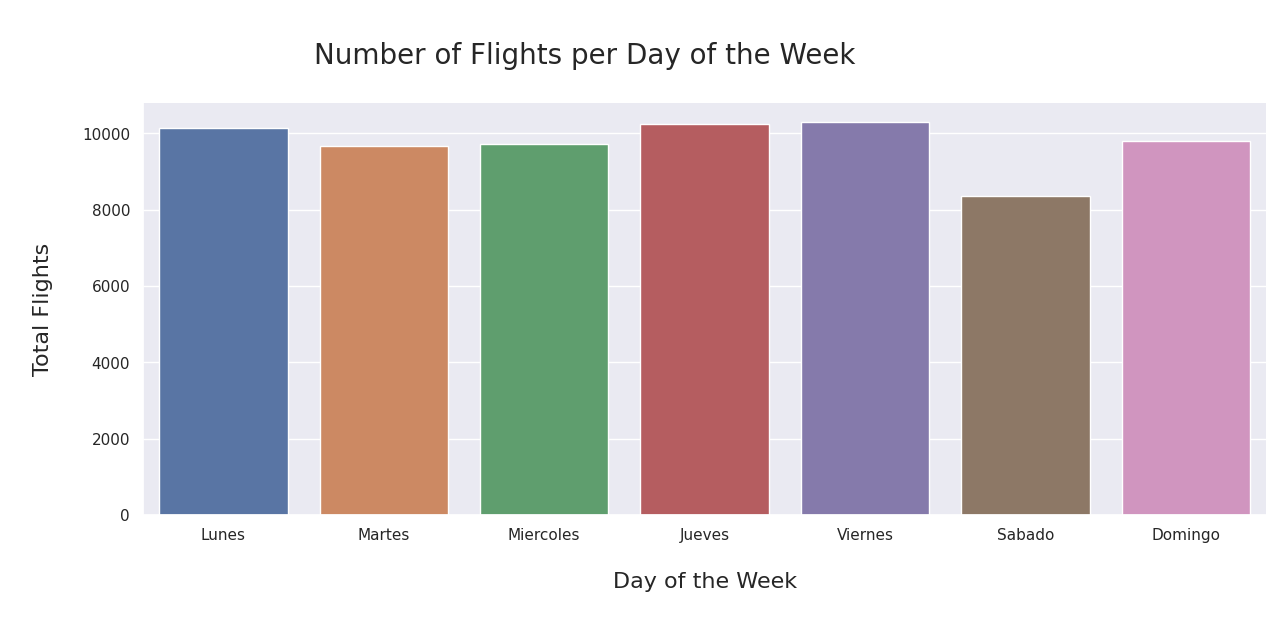

In [121]:
# Distribution of Flights vs Day of the Week

g = sns.catplot(
    x="DIANOM",
    data=dataset,
    kind="count",
    order=["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"],
)
g.set_axis_labels("\nDay of the Week\n", "\nTotal Flights\n", size=16)
g.fig.suptitle("\nNumber of Flights per Day of the Week", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

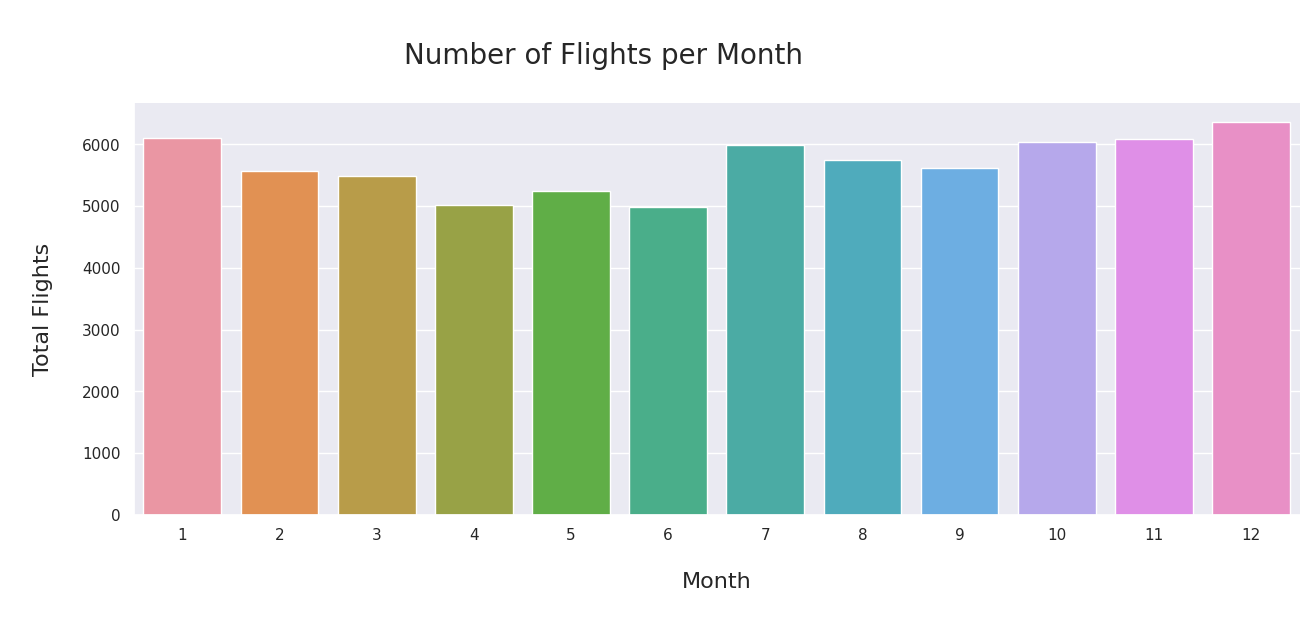

In [122]:
# Distribution of Flights vs Month

g = sns.catplot(x="MES", data=dataset, kind="count", order=range(1, 13))
g.set_axis_labels("\nMonth\n", "\nTotal Flights\n", size=16)
g.fig.suptitle("\nNumber of Flights per Month", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

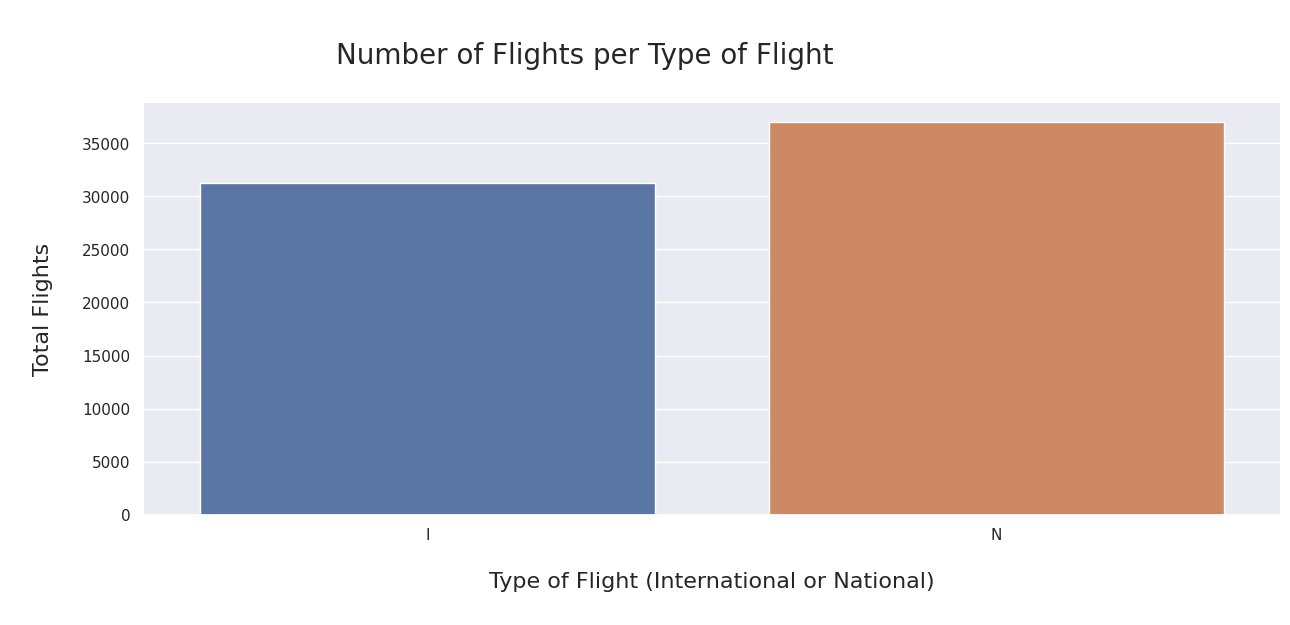

In [123]:
# Distribution of Flights vs Type of Flight

g = sns.catplot(x="TIPOVUELO", data=dataset, kind="count")
g.set_axis_labels(
    "\nType of Flight (International or National)\n", "\nTotal Flights\n", size=16
)
g.fig.suptitle("\nNumber of Flights per Type of Flight", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

In [124]:
# calculate percent of National and International Flights

national_pct = dataset[dataset["TIPOVUELO"] == "N"]["TIPOVUELO"].count() / len(dataset)

print(f"{national_pct:.1%} of Flights are National")
print(f"{1-national_pct:.1%} of Flights are International")

54.2% of Flights are National
45.8% of Flights are International


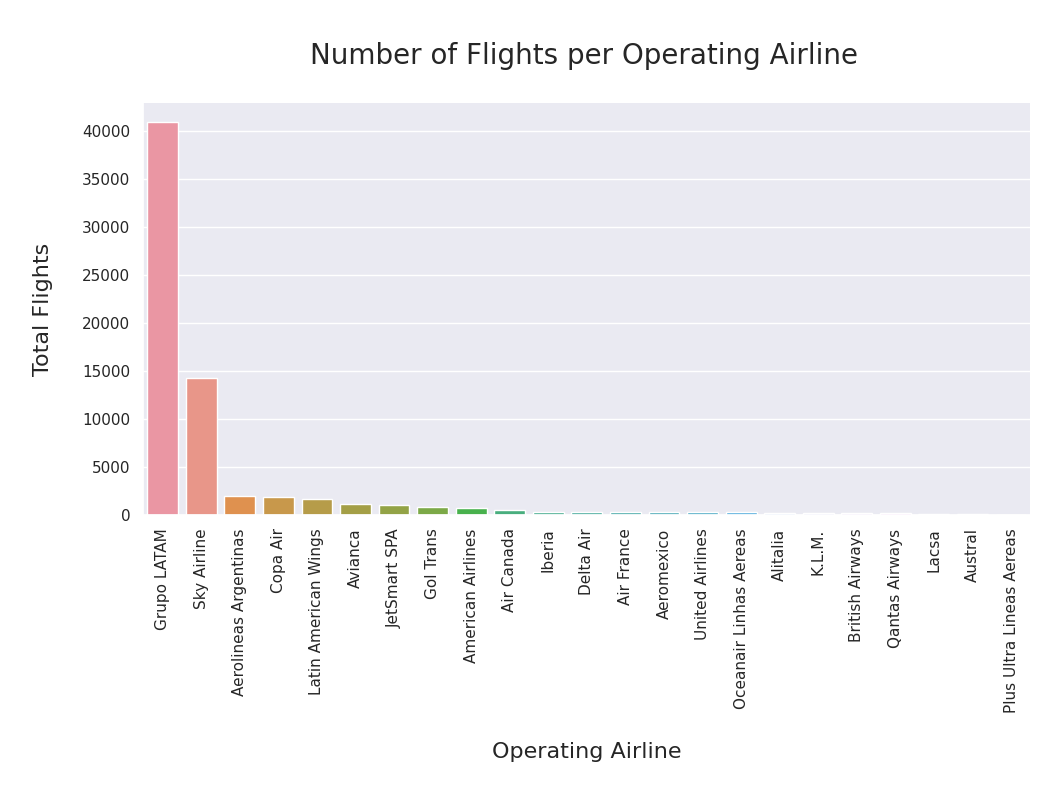

In [125]:
# Distribution of Flights per Operating Airline

g = sns.catplot(
    x="OPERA", data=dataset, kind="count", order=dataset["OPERA"].value_counts().index
)
g.set_axis_labels("\nOperating Airline\n", "\nTotal Flights\n", size=16)
g.fig.suptitle("\nNumber of Flights per Operating Airline", size=20, y=1.15)
g.figure.set_size_inches(15, 5)
# rotate xlabels
g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0f}")

In [126]:
# calculate percent for Airline 'Grupo LATAM' and 'Sky Airline
total_latam = dataset[dataset["OPERA"] == "Grupo LATAM"]["OPERA"].count()
total_sky = dataset[dataset["OPERA"] == "Sky Airline"]["OPERA"].count()

print(f"'Grupo LATAM' operates {total_latam/len(dataset):.1%} of the flights.")
print(f"'Sky Airline' operates {total_sky/len(dataset):.1%} of the flights.")
print(
    f"Together they account for {(total_sky+total_latam)/len(dataset):.1%} of flights."
)

'Grupo LATAM' operates 60.0% of the flights.
'Sky Airline' operates 21.0% of the flights.
Together they account for 80.9% of flights.


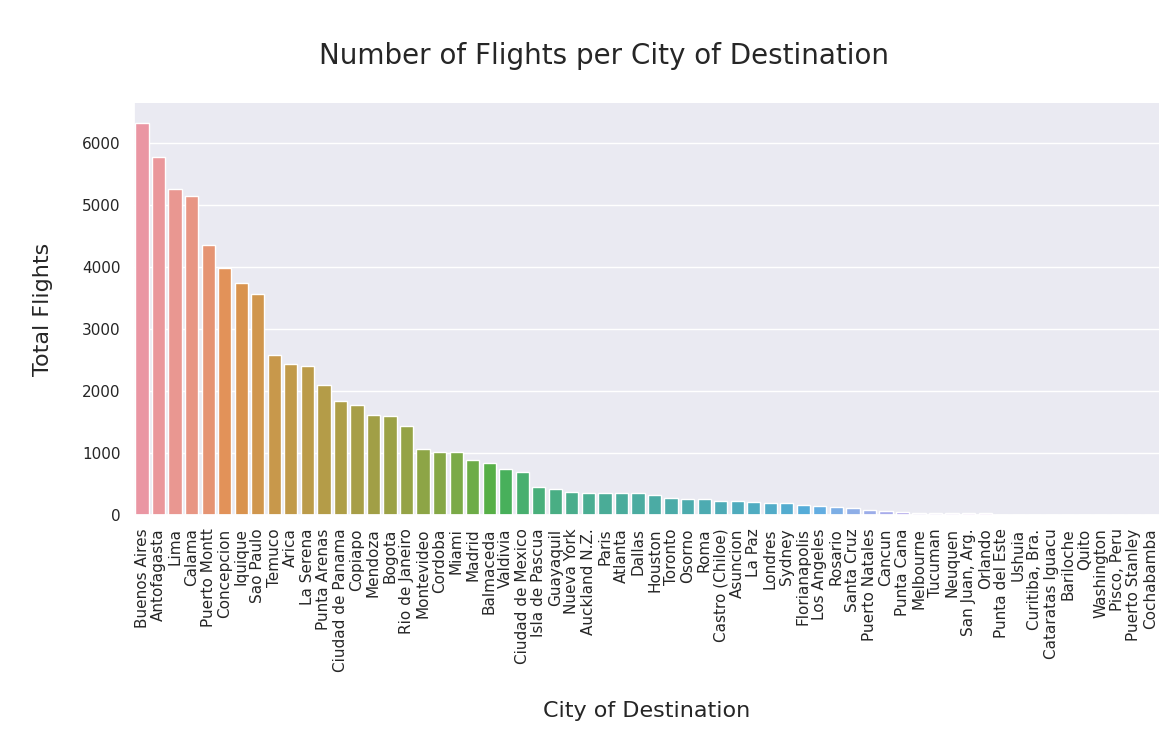

In [127]:
# Distribution of Flights per City of Destination

g = sns.catplot(
    x="SIGLADES",
    data=dataset,
    kind="count",
    order=dataset["SIGLADES"].value_counts().index,
)
g.set_axis_labels("\nCity of Destination\n", "\nTotal Flights\n", size=16)
g.fig.suptitle("\nNumber of Flights per City of Destination", size=20, y=1.15)
g.figure.set_size_inches(15, 5)
# rotate xlabels
g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0f}")

### 1.1 Main Conclusions and Interpretation:

1. On average, Saturday (**Sabado**) is the day with the least flights of the whole week. The rest days are similar but slightly higher for Monday (**Lunes**), Thursday (**Jueves**) and Friday (**Viernes**).
2. There is a difference in number of flights per month of the year, there are months with low demand (April/4, May/5 and June/6) and high demand (July/7, October/10, November/11, December/12 and January/1).
3. Slightly more than half (54.2%) of the flights are of '**National**' Type, while the rest (45.8%) are '**International**'.
4. Most flights are operated by '**Grupo LATAM**' (60%), followed by '**Sky Airline**' (21%). Together they account for 80.9% of total flights.
5. As seen previously (*not plotted*), the only City of Origin is '**Santiago**' de Chile.
6. The 5 most frequent destinations overall are (in descending order): '*Buenos Aires*', '*Antofagasta*', '*Lima*', '*Calama*' and '*Puerto Montt*'.	
7. The 5 most frequent **International** destinations are (in descending order): '*Buenos Aires*', '*Lima*', '*Sao Paulo*', '*Ciudad de Panama*' and '*Mendoza*'.
8. The 5 most frequent **National** destinations are (in descending order): '*Antofagasta*', '*Calama*', '*Puerto Montt*', '*Concepción*' e '*Iquique*'.

## 2. Create additional synthetic features

In [128]:
# create new synthetic features from the original data

synthetic_features = pd.DataFrame(
    [], columns=["temporada_alta", "dif_min", "atraso_15", "periodo_dia"]
)
synthetic_features

,temporada_alta,dif_min,atraso_15,periodo_dia


In [129]:
# new feature 'dif_min': difference in minutes between 'Fecha-O' and 'Fecha-I'.

synthetic_features["dif_min"] = dataset["Fecha-O"] - dataset["Fecha-I"]
synthetic_features["dif_min"] = synthetic_features["dif_min"].apply(
    lambda x: float(x.total_seconds() / 60.0)
)
synthetic_features["dif_min"]

0         3.0
1         9.0
2         9.0
3         3.0
4        -2.0
         ... 
68201    46.0
68202    16.0
68203    40.0
68204    13.0
68205     9.0
Name: dif_min, Length: 68206, dtype: float64

In [130]:
# new feature 'atraso_15': 1 if dif_min > 15, 0 if not.

synthetic_features["atraso_15"] = synthetic_features["dif_min"].apply(
    lambda x: 1 if x > 15 else 0
)
synthetic_features["atraso_15"]

0        0
1        0
2        0
3        0
4        0
        ..
68201    1
68202    1
68203    1
68204    0
68205    0
Name: atraso_15, Length: 68206, dtype: int64

In [131]:
# new feature 'temporada_alta': 1 if 'Fecha-I' is between 15-Dic and 3-Mar,
# or 15-Jul and 31-Jul, or 11-Sep and 30-Sep, 0 if not.

synthetic_features["temporada_alta"] = dataset["Fecha-I"].apply(
    lambda x: 1
    if (x > datetime(month=1, day=1, year=2017))
    and (x < datetime(month=3, day=3, year=2017))
    or (x > datetime(month=12, day=15, year=2017))
    and (x < datetime(month=3, day=3, year=2018))
    or (x > datetime(month=7, day=15, year=2017))
    and (x < datetime(month=7, day=31, year=2017))
    or (x > datetime(month=9, day=11, year=2017))
    and (x < datetime(month=9, day=30, year=2017))
    else 0
)

temporada_alta_pct = synthetic_features["temporada_alta"].sum() / len(dataset)
print(f"'temporada_alta' is true for {temporada_alta_pct:.1%} of the flights.")

'temporada_alta' is true for 32.6% of the flights.


In [132]:
# new feature 'periodo_dia': 'mañana' (if time between 5:00-11:59),
# 'tarde' (between 12:00-18:59) y 'noche' ( between 19:00-4:59), using 'Fecha-I'.

synthetic_features["periodo_dia"] = dataset["Fecha-I"].apply(
    lambda x: "mañana"
    if (x.hour >= 5) and (x.hour < 12)
    else "tarde"
    if (x.hour >= 12) and (x.hour < 19)
    else "noche"
)
synthetic_features["periodo_dia"]

0        noche
1        noche
2        noche
3        noche
4        noche
         ...  
68201    tarde
68202    tarde
68203    tarde
68204    tarde
68205    tarde
Name: periodo_dia, Length: 68206, dtype: object

In [133]:
# Export Synthetic Features to CSV file

synthetic_features.to_csv("output/synthetic_features.csv", index=False)
synthetic_features

,temporada_alta,dif_min,atraso_15,periodo_dia
0,1,3.0,0,noche
1,1,9.0,0,noche
2,1,9.0,0,noche
3,1,3.0,0,noche
4,1,-2.0,0,noche
...,...,...,...,...
68201,1,46.0,1,tarde
68202,1,16.0,1,tarde
68203,1,40.0,1,tarde
68204,1,13.0,0,tarde


## 3. Analyze Delay Features

In [134]:
# join synthetic features into main dataframe

dataset = dataset.join(synthetic_features)
dataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,noche


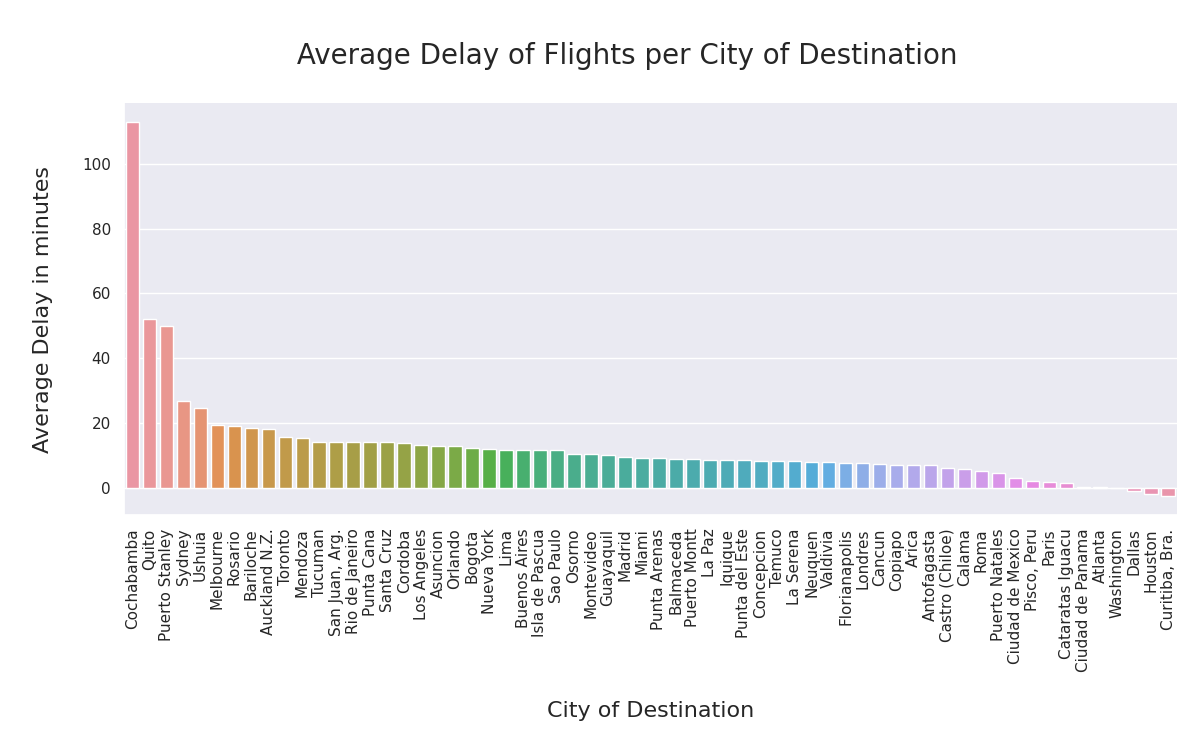

In [135]:
# Distribution of Average Delay per City of Destination

grouped_df = (
    dataset.groupby(by="SIGLADES", as_index=False)["dif_min"]
    .mean()
    .sort_values(by="dif_min", ascending=False)
)

g = sns.catplot(x="SIGLADES", y="dif_min", data=grouped_df, kind="bar")
g.set_axis_labels("\nCity of Destination\n", "\nAverage Delay in minutes\n", size=16)
g.fig.suptitle("\n Average Delay of Flights per City of Destination", size=20, y=1.15)
g.figure.set_size_inches(15, 5)
# rotate xlabels
g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0f}")

In [136]:
# Destinations with average delay > 15

grouped_df[grouped_df["dif_min"] > 15]

,SIGLADES,dif_min
15,Cochabamba,113.000000
48,Quito,52.000000
44,Puerto Stanley,50.000000
55,Sydney,26.948454
59,Ushuia,24.500000
32,Melbourne,19.256410
51,Rosario,19.022059
6,Bariloche,18.500000
4,Auckland N.Z.,18.246537
57,Toronto,15.766784


In [137]:
# 10 destinations with less delay

grouped_df.tail(10)

,SIGLADES,dif_min
13,Ciudad de Mexico,3.175714
41,"Pisco, Peru",2.000000
40,Paris,1.660167
12,Cataratas Iguacu,1.500000
14,Ciudad de Panama,0.214054
3,Atlanta,0.114525
61,Washington,0.000000
20,Dallas,-1.081232
23,Houston,-1.862275
19,"Curitiba, Bra.",-2.666667


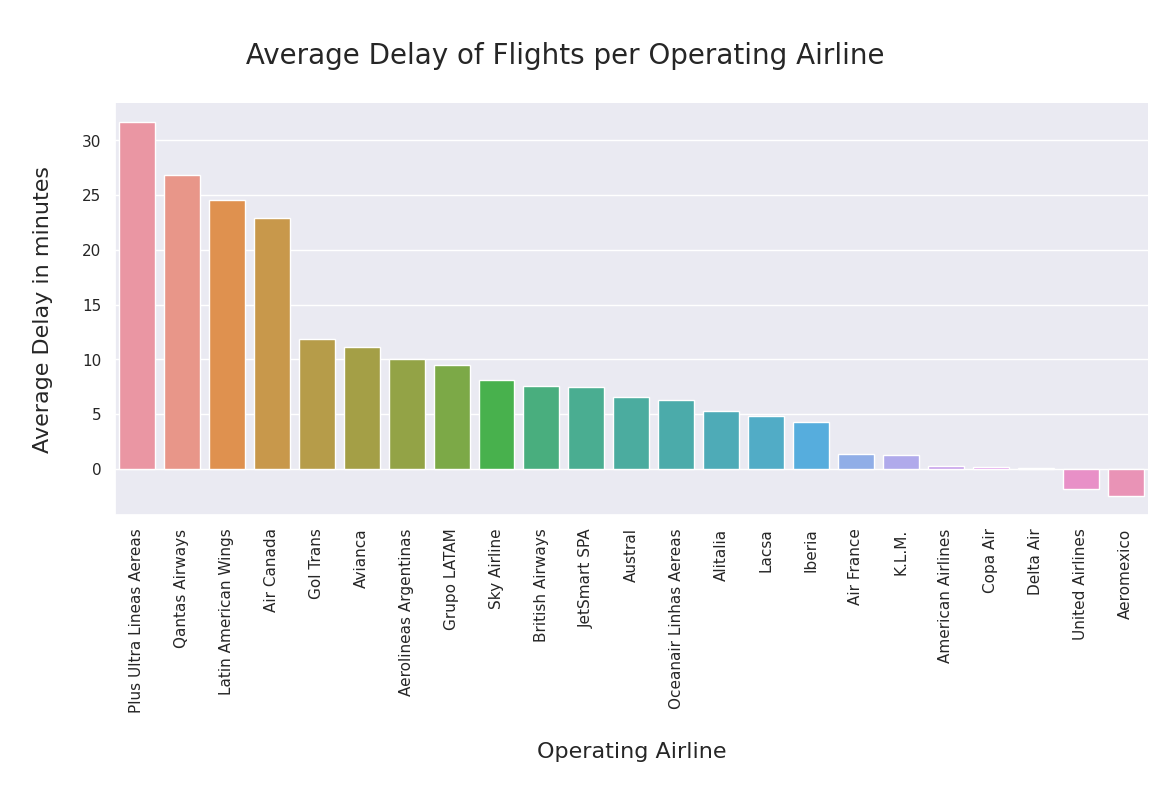

In [138]:
# Distribution of Average Delay per operating Airline

grouped_df = (
    dataset.groupby(by="OPERA", as_index=False)["dif_min"]
    .mean()
    .sort_values(by="dif_min", ascending=False)
)

g = sns.catplot(x="OPERA", y="dif_min", data=grouped_df, kind="bar")
g.set_axis_labels("\nOperating Airline\n", "\nAverage Delay in minutes\n", size=16)
g.fig.suptitle("\n Average Delay of Flights per Operating Airline", size=20, y=1.15)
g.figure.set_size_inches(15, 5)
# rotate xlabels
g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0f}")

In [139]:
# Airlines with average delay > 15

grouped_df[grouped_df["dif_min"] > 15]

,OPERA,dif_min
19,Plus Ultra Lineas Aereas,31.714286
20,Qantas Airways,26.835897
17,Latin American Wings,24.566308
2,Air Canada,22.909735


In [140]:
# 10 Airlines with less delay

grouped_df.tail(10)

,OPERA,dif_min
4,Alitalia,5.293436
16,Lacsa,4.880435
13,Iberia,4.276243
3,Air France,1.399441
15,K.L.M.,1.310757
5,American Airlines,0.277411
9,Copa Air,0.214054
10,Delta Air,0.114525
22,United Airlines,-1.856716
1,Aeromexico,-2.495726


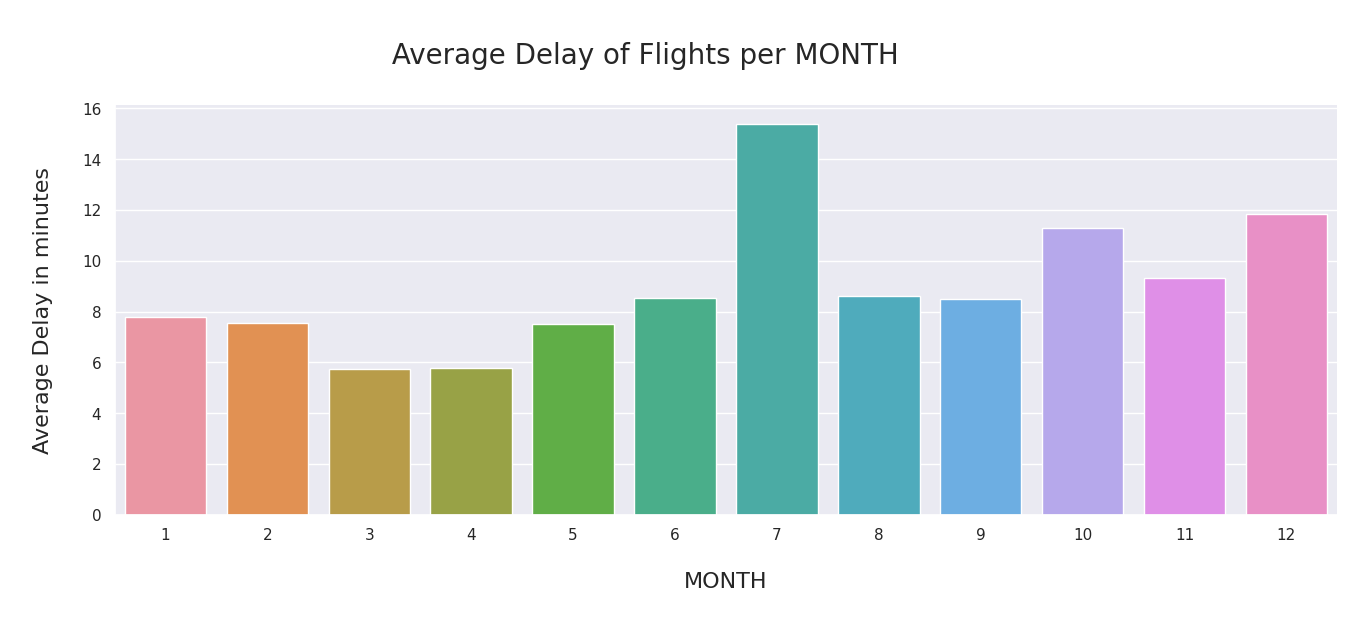

In [141]:
# Distribution of Average Delay per MONTH

grouped_df = (
    dataset.groupby(by="MES", as_index=False)["dif_min"]
    .mean()
    .sort_values(by="dif_min", ascending=False)
)

g = sns.catplot(x="MES", y="dif_min", data=grouped_df, kind="bar")
g.set_axis_labels("\nMONTH\n", "\nAverage Delay in minutes\n", size=16)
g.fig.suptitle("\n Average Delay of Flights per MONTH", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

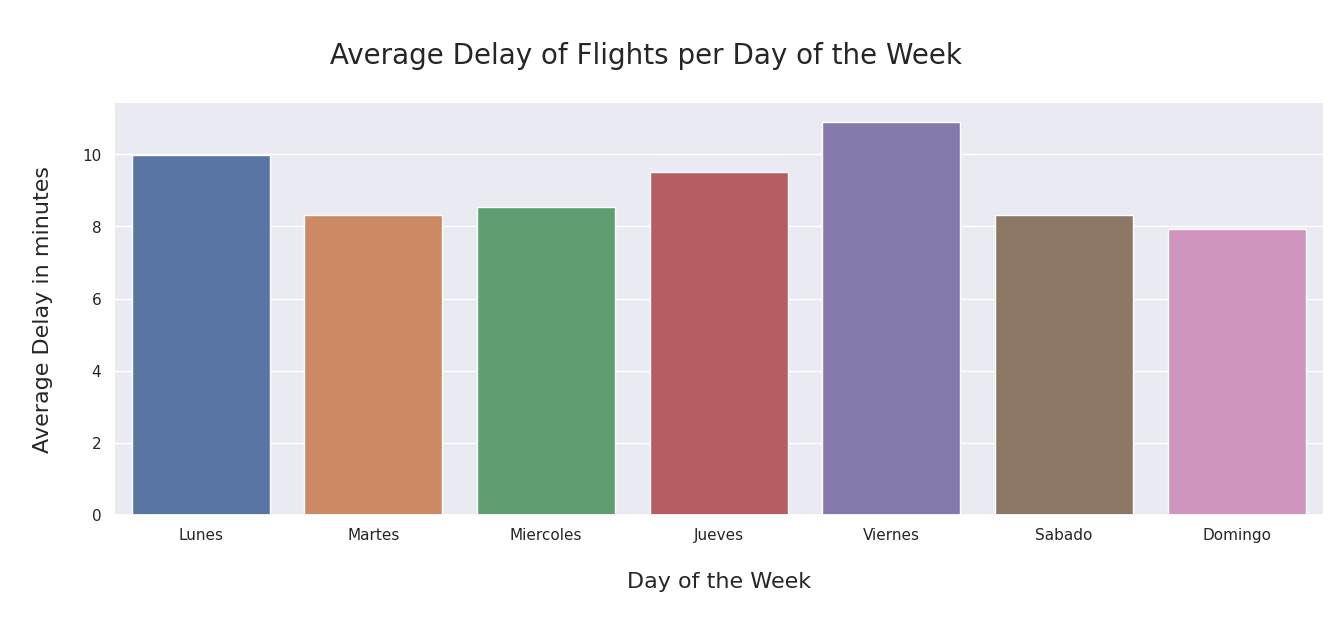

In [142]:
# día de la semana
# Distribution of Average Delay per Day of the Week

grouped_df = dataset.groupby(by="DIANOM", as_index=False)["dif_min"].mean()

g = sns.catplot(
    x="DIANOM",
    y="dif_min",
    data=grouped_df,
    kind="bar",
    order=["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"],
)
g.set_axis_labels("\nDay of the Week\n", "\nAverage Delay in minutes\n", size=16)
g.fig.suptitle("\n Average Delay of Flights per Day of the Week", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

In [143]:
# Correlation between Average Delay vs Season

dataset[["temporada_alta", "dif_min"]].corr(method="spearman")

,temporada_alta,dif_min
temporada_alta,1.000000,0.027534
dif_min,0.027534,1.000000


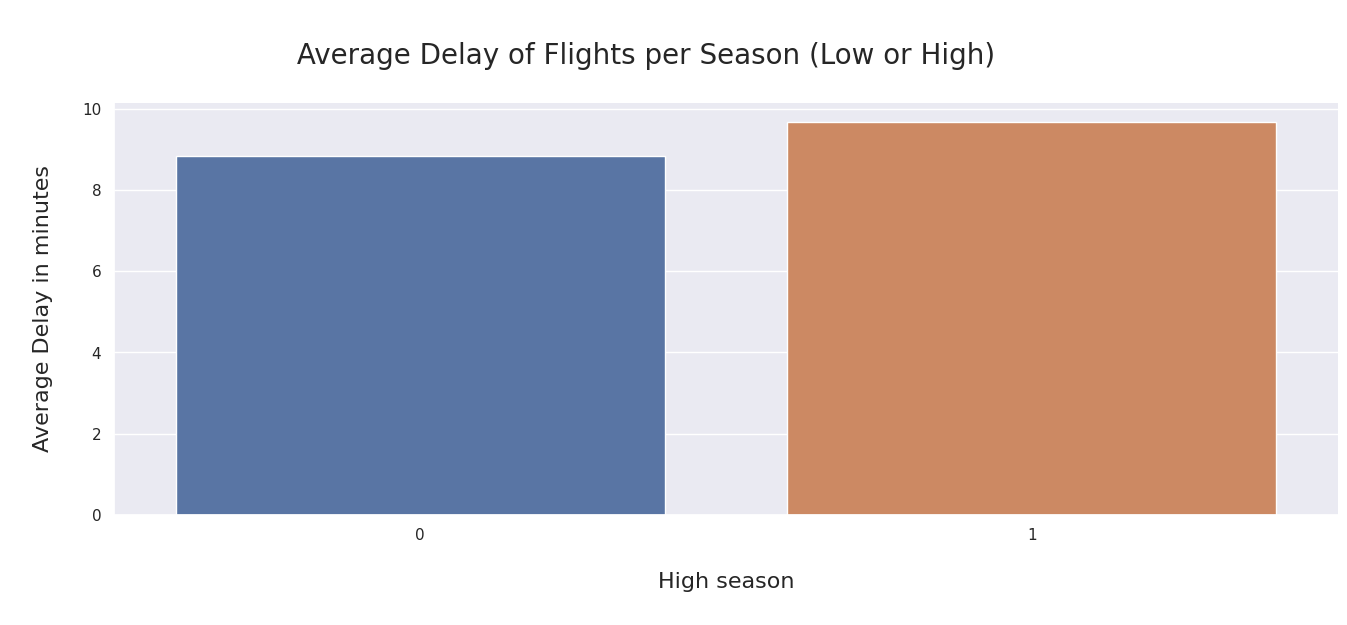

In [144]:
# Distribution of Average Delay per Season

grouped_df = (
    dataset.groupby(by="temporada_alta", as_index=False)["dif_min"]
    .mean()
    .sort_values(by="dif_min", ascending=False)
)

g = sns.catplot(x="temporada_alta", y="dif_min", data=grouped_df, kind="bar")
g.set_axis_labels("\nHigh season\n", "\nAverage Delay in minutes\n", size=16)
g.fig.suptitle("\n Average Delay of Flights per Season (Low or High)", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

In [145]:
grouped_df["dif_min"][1] - grouped_df["dif_min"][0]

0.8181817412966943

In [146]:
# Correlation between Average Delay vs Flight Type

pd.DataFrame(
    {
        "TIPOVUELO": dataset["TIPOVUELO"].replace({"I": 1, "N": 0}),
        "dif_min": dataset["dif_min"],
    }
).corr(method="spearman")

,TIPOVUELO,dif_min
TIPOVUELO,1.000000,0.056238
dif_min,0.056238,1.000000


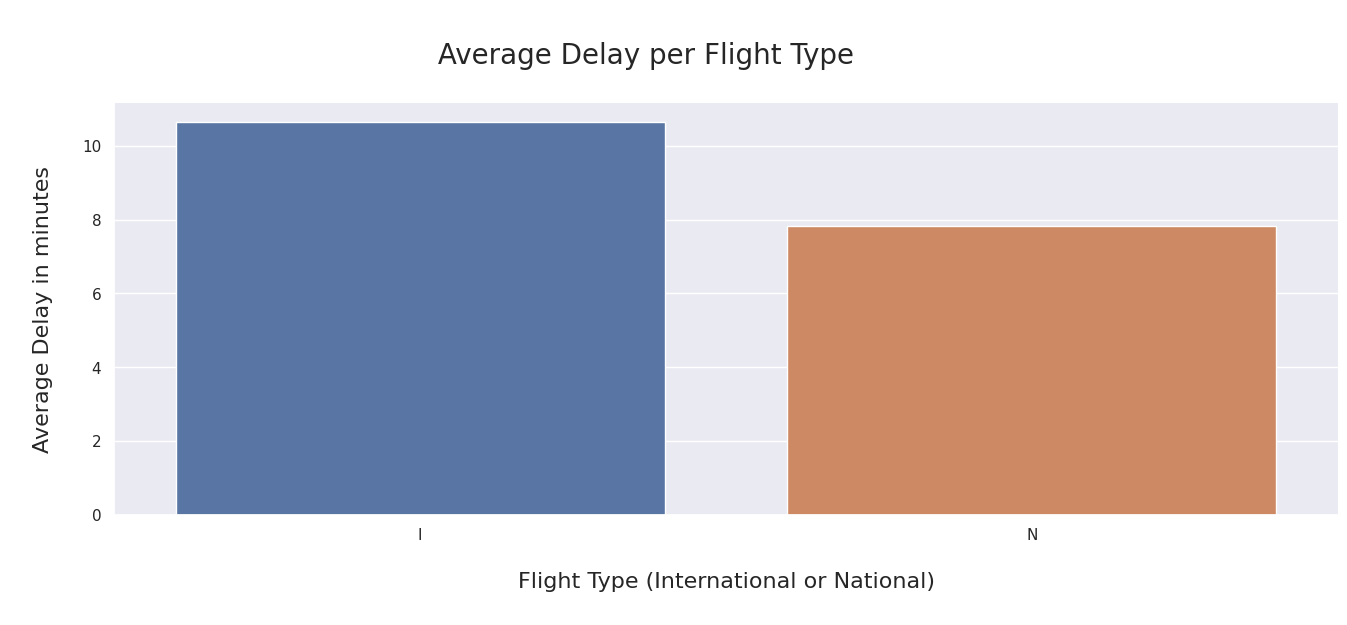

In [147]:
# Distribution of Average Delay per Flight Type

grouped_df = (
    dataset.groupby(by="TIPOVUELO", as_index=False)["dif_min"]
    .mean()
    .sort_values(by="dif_min", ascending=False)
)

g = sns.catplot(x="TIPOVUELO", y="dif_min", data=grouped_df, kind="bar")
g.set_axis_labels(
    "\nFlight Type (International or National)\n",
    "\nAverage Delay in minutes\n",
    size=16,
)
g.fig.suptitle("\n Average Delay per Flight Type", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

In [148]:
grouped_df["dif_min"][0] - grouped_df["dif_min"][1]

2.819382625748144

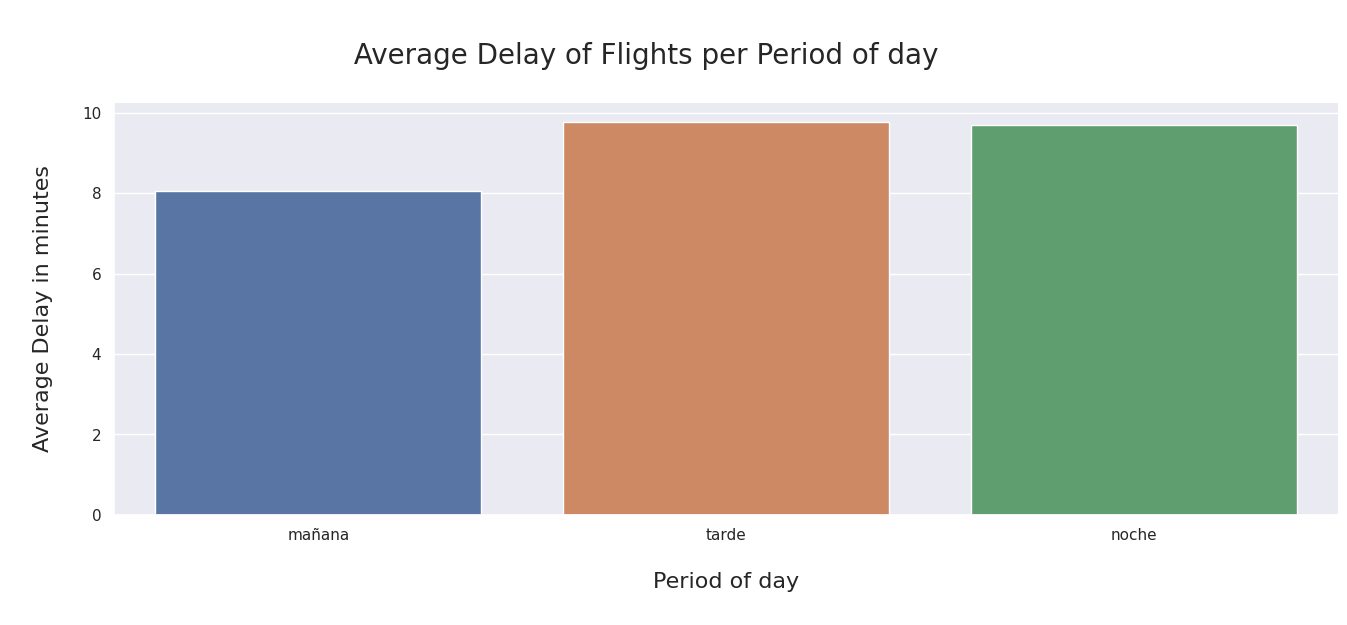

In [149]:
# Distribution of Average Delay per period of day

grouped_df = dataset.groupby(by="periodo_dia", as_index=False)["dif_min"].mean()

g = sns.catplot(
    x="periodo_dia",
    y="dif_min",
    data=grouped_df,
    kind="bar",
    order=["mañana", "tarde", "noche"],
)
g.set_axis_labels("\nPeriod of day\n", "\nAverage Delay in minutes\n", size=16)
g.fig.suptitle("\n Average Delay of Flights per Period of day", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

In [150]:
grouped_df

,periodo_dia,dif_min
0,mañana,8.061534
1,noche,9.694086
2,tarde,9.757155


### 3.1 Main Conclusions and Interpretation:

1. There are 11 destinations that are more than 15 minutes late on average, they are: 'Cochabamba', 'Quito', 'Puerto Stanley', 'Sydney', 'Ushuia', 'Melbourne', 'Rosario', 'Bariloche', 'Auckland N.Z.', 'Toronto' and 'Mendoza'.
2. The average delay for 'Cochabamba', 'Quito' and 'Puerto Stanley' is over 50 minutes.
3. The 10 less delayed destinatios are: 'Ciudad de Mexico', 'Pisco, Peru', 'Paris', 'Cataratas Iguacu', 'Ciudad de Panama', 'Atlanta', 'Washington', 'Dallas', 'Houston', 'Curitiba, Bra.'.
4. The average delay for 'Ciudad de Panama', 'Atlanta' and 'Washington' is less than 1 minute.
5. 'Dallas', 'Houston' and 'Curitiba, Bra.' depart more than 1 minute early on average.
6. The Airlines with more than 15 minutes of average delay are: 'Plus Ultra Lineas Aereas', 'Qantas Airways', 'Latin American Wings', 'Air Canada'.
7. The 10 less delayed Airlines are: 'Alitalia', 'Lacsa', 'Iberia', 'Air France', 'K.L.M.', 'American Airlines', 'Copa Air', 'Delta Air', 'United Airlines', 'Aeromexico'.
8. 'Air France', 'K.L.M.', 'American Airlines', 'Copa Air' and 'Delta Air' are delayed less than 2 minutes on average.
9. 'United Airlines' and 'Aeromexico' depart around 2 minutes early on average.
10. The most delayed Months are July/7, October/10 and December/12, with July having an average delay of more than 15 minutes.
11. The week days with highest average delay are Monday (Lunes) and Friday (Viernes). The least delays occur on Sunday (Domingo).
12. There is a very little difference of 0.82 minutes of additional delay on average between High and Low season
13. There is a positive but low 'spearman' correlation of 0.0275 between minutes of delay and high_season. This means that there is a little effect of season on delay but is not a strong feature on its own to predict delay. The Spearman correlation is used over the typical Pearson correlation because it assesses monotonic relationships (whether linear or not linear).
14. There is a little difference of 2.82 minutes of additional delay on average between the Type of Flight (International or National).
15. There is a positive but low 'spearman' correlation of 0.056 between minutes of delay and Type of Flight. This means that there is a little effect of season on delay but is not a strong feature on its own to predict delay.
16. The average delay on the morning flights is around 1.7 minutes less than on the afternoon and night.

### 3.2 What would be the most important features to predict delays? 

According to the previous analysis and observations, the best features would be those that showed a strong variation between the feature categories and the delay in minutes.

Features with big influence:
- City of Destination ('SIGLADES')
- Operating Airline ('OPERA)
- Month ('MES')
- Day of Week ('DIANOM')

Features with medium influence:
- Flight Type ('TIPOVUELO')
- Period of day ('periodo_dia')

Features with small influence:
- High season ('temporada_alta'): did not show so much strength, but using the exact dates could introduce a better signal for the model.

## 4. Create Machine Learning Model(s)
- The main goal is to estimate the probability of delay for a flight.
- Delay is assumed as a binary class with 1 meaning that the flight departed with > 15min delay.
- The Model must be a binary classifier and transform score into probability
- Optional: create another regression model to predict the exact delay in minutes. => minutes of delay could also be transformed into delay probability.

### 4.1 Include Additional Features

- did a change occur to the flight program ? (between programmed and operation data) => **Is this data known a priori?**
- use date as 'mes-dia' categorical feature, ignore year (careful not to over-fit)
- include list of holidays for chile, non-working days, school vacations, etc.
- include meteorological data for SCL Airport (Arturo Merino Benitez)
- Try various ML and Deep Neural Network models.
- Optimize hyperparameters to increase performance

In [151]:
# Did the program change (not sure if this information is known before the delay
# The mode should be trained with and without this data

dataset["Vlo-change"] = [
    1 if vloi != vloo else 0 for vloi, vloo in zip(dataset["Vlo-I"], dataset["Vlo-O"])
]
dataset["Des-change"] = [
    1 if desi != deso else 0 for desi, deso in zip(dataset["Des-I"], dataset["Des-O"])
]
dataset["Emp-change"] = [
    1 if empi != empo else 0 for empi, empo in zip(dataset["Emp-I"], dataset["Emp-O"])
]
dataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia,Vlo-change,Des-change,Emp-change
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,3.0,0,noche,0,0,0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,9.0,0,noche,0,0,0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,9.0,0,noche,0,0,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,3.0,0,noche,0,0,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,-2.0,0,noche,0,0,0


In [152]:
# Correlation between Average Delay vs Change of Vlo

pd.DataFrame(
    {
        "Vlo-change": dataset["Vlo-change"],
        "dif_min": dataset["dif_min"],
    }
).corr(method="spearman")

,Vlo-change,dif_min
Vlo-change,1.000000,0.046132
dif_min,0.046132,1.000000


In [153]:
# Correlation between Average Delay vs Change of Des

pd.DataFrame(
    {
        "Des-change": dataset["Des-change"],
        "dif_min": dataset["dif_min"],
    }
).corr(method="spearman")

,Des-change,dif_min
Des-change,1.000000,0.007626
dif_min,0.007626,1.000000


In [154]:
# Correlation between Average Delay vs Change of Emp

pd.DataFrame(
    {
        "Emp-change": dataset["Emp-change"],
        "dif_min": dataset["dif_min"],
    }
).corr(method="spearman")

,Emp-change,dif_min
Emp-change,1.000000,0.048564
dif_min,0.048564,1.000000


Didn't find strong correlation between the Delay and changes in the Flight Program

### Specific Dates

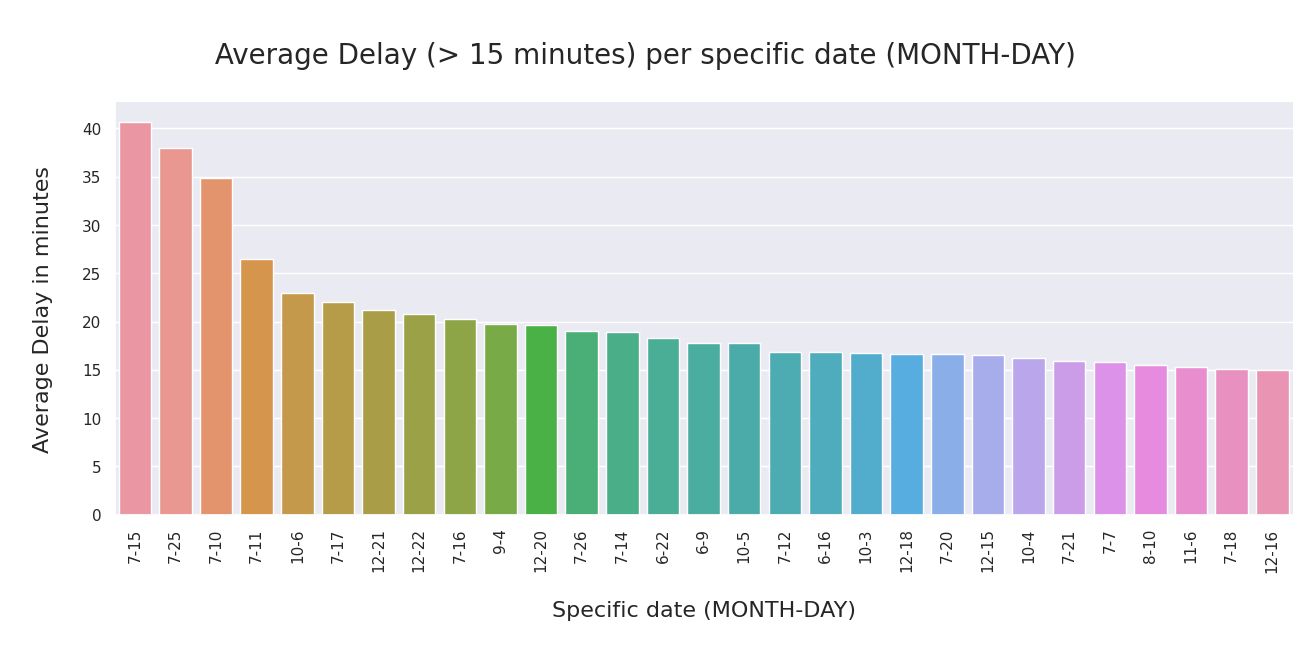

In [155]:
# Distribution of Average Delay per specific date (MONTH-DAY)

# create Month-Day feature
dataset["MES-DIA"] = dataset["MES"].astype(str) + "-" + dataset["DIA"].astype(str)

grouped_df = (
    dataset.groupby(by="MES-DIA", as_index=False)["dif_min"]
    .mean()
    .sort_values(by="dif_min", ascending=False)
)

g = sns.catplot(
    x="MES-DIA", y="dif_min", data=grouped_df[grouped_df["dif_min"] > 15], kind="bar"
)
g.set_axis_labels(
    "\nSpecific date (MONTH-DAY)\n", "\nAverage Delay in minutes\n", size=16
)
g.fig.suptitle(
    "\n Average Delay (> 15 minutes) per specific date (MONTH-DAY)", size=20, y=1.15
)
g.figure.set_size_inches(15, 5)
# rotate xlabels
g.set_xticklabels(rotation=90)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0f}")

Average Delay seems to be more associated with specific date combinations than simply using the High/Low season periods.

#### Metereological Data
According to a [report](https://www.transportation.gov/sites/dot.gov/files/docs/kulesa_Weather_Aviation.pdf) from the US Federal Aviation Administration (FAA), weather conditions cause ~70% of the delays in the US National Airspace System.

Because metereological conditions are very important variables that could cause delays, data for SCL Airport was downloaded from https://climatologia.meteochile.gob.cl/ and included in the `input/additional_data/` folder.

In [156]:
# Relative Humidity per Hour
humidity = pd.concat(
    [
        pd.read_csv(
            "input/additional_data/330021_2017_Humedad_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
        pd.read_csv(
            "input/additional_data/330021_2018_Humedad_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
    ],
    axis=0,
    ignore_index=True,
)
humidity.rename(
    columns={"momento": "date", "HR_Valor": "relative_humidity"}, inplace=True
)
humidity["date"] = humidity["date"].apply(
    lambda x: datetime.strptime(x, "%d-%m-%Y %H:%M:%S")
)
humidity.set_index("date", inplace=True)
humidity["relative_humidity"] = humidity["relative_humidity"].apply(lambda x: x / 100)
humidity = humidity.interpolate(method="linear")
humidity.drop(columns=["CodigoNacional"], inplace=True)
humidity

,relative_humidity
date,
2017-01-01 00:00:00,0.56
2017-01-01 01:00:00,0.58
2017-01-01 02:00:00,0.65
2017-01-01 03:00:00,0.64
2017-01-01 04:00:00,0.69
...,...
2018-12-31 19:00:00,0.19
2018-12-31 20:00:00,0.20
2018-12-31 21:00:00,0.18


In [157]:
# Dew point (the temperature in which air becomes saturated with water vapor)

dew_point = pd.concat(
    [
        pd.read_csv(
            "input/additional_data/330021_2017_PuntoRocio_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
        pd.read_csv(
            "input/additional_data/330021_2018_PuntoRocio_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
    ],
    axis=0,
    ignore_index=True,
)
dew_point.rename(columns={"momento": "date", "Td_Valor": "dew_point"}, inplace=True)
dew_point["date"] = dew_point["date"].apply(
    lambda x: datetime.strptime(x, "%d-%m-%Y %H:%M:%S")
)
dew_point.set_index("date", inplace=True)
dew_point = dew_point.interpolate(method="time")
dew_point.drop(columns=["CodigoNacional"], inplace=True)
dew_point

,dew_point
date,
2017-01-01 00:00:00,11.7
2017-01-01 01:00:00,11.8
2017-01-01 02:00:00,11.4
2017-01-01 03:00:00,11.2
2017-01-01 04:00:00,11.2
...,...
2018-12-31 19:00:00,5.7
2018-12-31 20:00:00,5.5
2018-12-31 21:00:00,3.5


In [158]:
# Air Temperature per hour

temp = pd.concat(
    [
        pd.read_csv(
            "input/additional_data/330021_2017_Temperatura_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
        pd.read_csv(
            "input/additional_data/330021_2018_Temperatura_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
    ],
    axis=0,
    ignore_index=True,
)
temp.rename(columns={"momento": "date", "Ts_Valor": "temperature"}, inplace=True)
temp["date"] = temp["date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))
temp.set_index("date", inplace=True)
temp = temp.interpolate(method="time")
temp.drop(columns=["CodigoNacional"], inplace=True)
temp

,temperature
date,
2017-01-01 00:00:00,20.6
2017-01-01 01:00:00,19.9
2017-01-01 02:00:00,18.0
2017-01-01 03:00:00,18.2
2017-01-01 04:00:00,16.8
...,...
2018-12-31 19:00:00,31.8
2018-12-31 20:00:00,30.7
2018-12-31 21:00:00,30.1


In [159]:
# Relative precipitation per Hour (6-hr interval interpolated to 1-hr interval)
precipitation = pd.concat(
    [
        pd.read_csv(
            "input/additional_data/330021_2017_Agua6Horas_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
        pd.read_csv(
            "input/additional_data/330021_2018_Agua6Horas_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
    ],
    axis=0,
    ignore_index=True,
)
precipitation.rename(columns={"momento": "date", "RRR6_Valor": "rain_mm"}, inplace=True)
precipitation["date"] = precipitation["date"].apply(
    lambda x: datetime.strptime(x, "%d-%m-%Y %H:%M:%S")
)
precipitation.set_index("date", inplace=True)
# reindex interval from 6 hours to 1 hour difference
precipitation = precipitation.reindex(
    pd.date_range("2017-01-01 00:00:00", "2018-12-31 23:00:00", freq="H")
)
# interpolate missing values then normalize to maintain the same total mm of rain
precipitation = precipitation.interpolate(method="time").apply(lambda x: x / 6)
precipitation.drop(columns=["CodigoNacional", "Traza_Valor"], inplace=True)
precipitation

,rain_mm
2017-01-01 00:00:00,0.0
2017-01-01 01:00:00,0.0
2017-01-01 02:00:00,0.0
2017-01-01 03:00:00,0.0
2017-01-01 04:00:00,0.0
...,...
2018-12-31 19:00:00,0.0
2018-12-31 20:00:00,0.0
2018-12-31 21:00:00,0.0
2018-12-31 22:00:00,0.0


Presence of Fog:

If the temperature of the air is around 2.5ºC of the dew point temperature, then the water vapor condensed will remain suspended in the air in the form of tiny droplets of water forming a fog. Also if Relative Humidty > 95%

In [160]:
# Formation of Fog per Hour

fog = [
    1
    if abs(temp.loc[date, "temperature"] - dew_point.loc[date, "dew_point"]) <= 2.5
    or humidity.loc[date, "relative_humidity"] >= 0.95
    else 0
    for date in temp.index
]
fog = pd.DataFrame(fog, index=temp.index, columns=["fog"])
fog

,fog
date,
2017-01-01 00:00:00,0
2017-01-01 01:00:00,0
2017-01-01 02:00:00,0
2017-01-01 03:00:00,0
2017-01-01 04:00:00,0
...,...
2018-12-31 19:00:00,0
2018-12-31 20:00:00,0
2018-12-31 21:00:00,0


Presence of Ice and Frost:

When temperature is below 2ºC as measured on air, the ground is close to or under 0ºC which forms ice (cold air descends).

If it's raining then there will be ice formed on the runway.

Also, if the air temperature is below the dew point, then the condensed water vapor will form dew that will turn into frost on the runway.

In [161]:
# Formation of Frost per Hour
frost = [
    1
    if temp.loc[date, "temperature"] <= 2
    and (temp.loc[date, "temperature"] < dew_point.loc[date, "dew_point"])
    or precipitation.loc[date, "rain_mm"] > 0
    else 0
    for date in temp.index
]
frost = pd.DataFrame(frost, index=temp.index, columns=["frost"])
frost

,frost
date,
2017-01-01 00:00:00,0
2017-01-01 01:00:00,0
2017-01-01 02:00:00,0
2017-01-01 03:00:00,0
2017-01-01 04:00:00,0
...,...
2018-12-31 19:00:00,0
2018-12-31 20:00:00,0
2018-12-31 21:00:00,0


In [162]:
# Cloud Coverage per Day (resample to hour, interpolating data)
cloud_coverage = pd.concat(
    [
        pd.read_csv(
            "input/additional_data/330021_2017_CieloCubierto_.csv.zip",
            compression="zip",
            sep=",",
        ),
        pd.read_csv(
            "input/additional_data/330021_2018_CieloCubierto_.csv.zip",
            compression="zip",
            sep=",",
        ),
    ],
    axis=0,
    ignore_index=True,
)
cloud_coverage["Cloud Coverage %"] = cloud_coverage["Octavas de Cielo Cubierto"].apply(
    lambda x: x / 8
)
cloud_coverage.rename(columns={"Fecha": "date"}, inplace=True)
cloud_coverage["date"] = cloud_coverage["date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)
cloud_coverage.set_index("date", inplace=True)
# change values to 1 hour, interpolating missing values
cloud_coverage = cloud_coverage.reindex(
    pd.date_range("2017-01-01 00:00:00", "2018-12-31 23:00:00", freq="H")
)
cloud_coverage = cloud_coverage.interpolate(method="time")
cloud_coverage.drop(columns="Octavas de Cielo Cubierto", inplace=True)
cloud_coverage

,Cloud Coverage %
2017-01-01 00:00:00,0.125000
2017-01-01 01:00:00,0.119792
2017-01-01 02:00:00,0.114583
2017-01-01 03:00:00,0.109375
2017-01-01 04:00:00,0.104167
...,...
2018-12-31 19:00:00,0.000000
2018-12-31 20:00:00,0.000000
2018-12-31 21:00:00,0.000000
2018-12-31 22:00:00,0.000000


In [163]:
# Wind per Hour
wind = pd.concat(
    [
        pd.read_csv(
            "input/additional_data/330021_2017_Viento_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
        pd.read_csv(
            "input/additional_data/330021_2018_Viento_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
    ],
    axis=0,
    ignore_index=True,
)
wind.rename(columns={"momento": "date", "ff_Valor": "wind_speed"}, inplace=True)
wind["date"] = wind["date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))
wind.set_index("date", inplace=True)
wind = wind.interpolate(method="time")
wind.drop(columns=["CodigoNacional", "dd_Valor", "VRB_Valor"], inplace=True)
wind

,wind_speed
date,
2017-01-01 00:00:00,13.0
2017-01-01 01:00:00,7.0
2017-01-01 02:00:00,9.0
2017-01-01 03:00:00,7.0
2017-01-01 04:00:00,7.0
...,...
2018-12-31 19:00:00,14.0
2018-12-31 20:00:00,16.0
2018-12-31 21:00:00,18.0


In [164]:
# Atmospheric pressure
atm_pressure = pd.concat(
    [
        pd.read_csv(
            "input/additional_data/330021_2017_PresionQFE_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
        pd.read_csv(
            "input/additional_data/330021_2018_PresionQFE_.csv.zip",
            compression="zip",
            sep=";|,",
        ),
    ],
    axis=0,
    ignore_index=True,
)
atm_pressure.rename(columns={"momento": "date", "QFE_Valor": "pressure"}, inplace=True)
atm_pressure["date"] = atm_pressure["date"].apply(
    lambda x: datetime.strptime(x, "%d-%m-%Y %H:%M:%S")
)
atm_pressure.set_index("date", inplace=True)
atm_pressure = atm_pressure.interpolate(method="time")
atm_pressure.drop(columns=["CodigoNacional"], inplace=True)
atm_pressure

,pressure
date,
2017-01-01 00:00:00,960.3
2017-01-01 01:00:00,961.0
2017-01-01 02:00:00,961.3
2017-01-01 03:00:00,961.0
2017-01-01 04:00:00,961.6
...,...
2018-12-31 19:00:00,955.0
2018-12-31 20:00:00,954.2
2018-12-31 21:00:00,953.7


In [165]:
# Merge Meteorological data into one dataframe

weather = pd.concat(
    [cloud_coverage, atm_pressure, fog, frost, wind, temp, precipitation, humidity],
    axis=1,
)
# fill NaN's with previous value
weather.fillna(method="ffill", inplace=True)
weather

,Cloud Coverage %,pressure,fog,frost,wind_speed,temperature,rain_mm,relative_humidity
2017-01-01 00:00:00,0.125000,960.3,0.0,0.0,13.0,20.6,0.0,0.56
2017-01-01 01:00:00,0.119792,961.0,0.0,0.0,7.0,19.9,0.0,0.58
2017-01-01 02:00:00,0.114583,961.3,0.0,0.0,9.0,18.0,0.0,0.65
2017-01-01 03:00:00,0.109375,961.0,0.0,0.0,7.0,18.2,0.0,0.64
2017-01-01 04:00:00,0.104167,961.6,0.0,0.0,7.0,16.8,0.0,0.69
...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.000000,955.0,0.0,0.0,14.0,31.8,0.0,0.19
2018-12-31 20:00:00,0.000000,954.2,0.0,0.0,16.0,30.7,0.0,0.20
2018-12-31 21:00:00,0.000000,953.7,0.0,0.0,18.0,30.1,0.0,0.18
2018-12-31 22:00:00,0.000000,953.6,0.0,0.0,16.0,29.2,0.0,0.18


In [166]:
# Are there still NaN's ?

weather.isna().sum().sum()

0

### Add Holiday data

In [167]:
dataset[["Fecha-I", "AÑO", "MES", "DIA"]]

,Fecha-I,AÑO,MES,DIA
0,2017-01-01 23:30:00,2017,1,1
1,2017-01-02 23:30:00,2017,1,2
2,2017-01-03 23:30:00,2017,1,3
3,2017-01-04 23:30:00,2017,1,4
4,2017-01-05 23:30:00,2017,1,5
...,...,...,...,...
68201,2017-12-22 14:55:00,2017,12,22
68202,2017-12-25 14:55:00,2017,12,25
68203,2017-12-27 14:55:00,2017,12,27
68204,2017-12-29 14:55:00,2017,12,29


In [168]:
# Load Holidays applicable to Chile

CL_holidays = holidays.Chile()
# list comprehension to mark holidays as 1 and non-holidays as 0
is_holiday = [1 if date in CL_holidays else 0 for date in dataset["Fecha-I"]]
# add column to dataset
dataset["is_holiday"] = is_holiday
dataset

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia,Vlo-change,Des-change,Emp-change,MES-DIA,is_holiday
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Miami,1,3.0,0,noche,0,0,0,1-1,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Miami,1,9.0,0,noche,0,0,0,1-2,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Miami,1,9.0,0,noche,0,0,0,1-3,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miami,1,3.0,0,noche,0,0,0,1-4,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Miami,1,-2.0,0,noche,0,0,0,1-5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,...,Lima,1,46.0,1,tarde,0,0,0,12-22,0
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,...,Lima,1,16.0,1,tarde,0,0,0,12-25,1
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,Lima,1,40.0,1,tarde,0,0,0,12-27,0
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,Lima,1,13.0,0,tarde,0,0,0,12-29,0


In [169]:
# Correlation between Average Delay vs Holidays

pd.DataFrame(
    {
        "is_holiday": dataset["is_holiday"],
        "dif_min": dataset["dif_min"],
    }
).corr(method="spearman")

,is_holiday,dif_min
is_holiday,1.00000,-0.04283
dif_min,-0.04283,1.00000


Delay doesn't seem to be correlated to holidays (it even shows a weak negative corr)

### Add School Vacation data

In [170]:
# new feature 'temporada_alta': 1 if 'Fecha-I' is between 15-Dic and 3-Mar,
# or 15-Jul and 31-Jul, or 11-Sep and 30-Sep, 0 if not.

dataset["is_school_vacation"] = dataset["Fecha-I"].apply(
    lambda x: 1
    if (x >= datetime(month=1, day=1, year=2017))
    and (x <= datetime(month=3, day=6, year=2017))
    or (x >= datetime(month=7, day=10, year=2017))
    and (x <= datetime(month=7, day=21, year=2017))
    or (x >= datetime(month=9, day=17, year=2017))
    and (x <= datetime(month=9, day=21, year=2017))
    or (x >= datetime(month=12, day=13, year=2017))
    else 0
)
dataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,temporada_alta,dif_min,atraso_15,periodo_dia,Vlo-change,Des-change,Emp-change,MES-DIA,is_holiday,is_school_vacation
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,3.0,0,noche,0,0,0,1-1,1,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,9.0,0,noche,0,0,0,1-2,1,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,9.0,0,noche,0,0,0,1-3,0,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,3.0,0,noche,0,0,0,1-4,0,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,-2.0,0,noche,0,0,0,1-5,0,1


In [171]:
# Correlation between Average Delay vs School Vacation

pd.DataFrame(
    {
        "is_school_vacation": dataset["is_school_vacation"],
        "dif_min": dataset["dif_min"],
    }
).corr(method="spearman")

,is_school_vacation,dif_min
is_school_vacation,1.000000,0.038269
dif_min,0.038269,1.000000


There's only a weak positive correlation between School Vacations and Delays

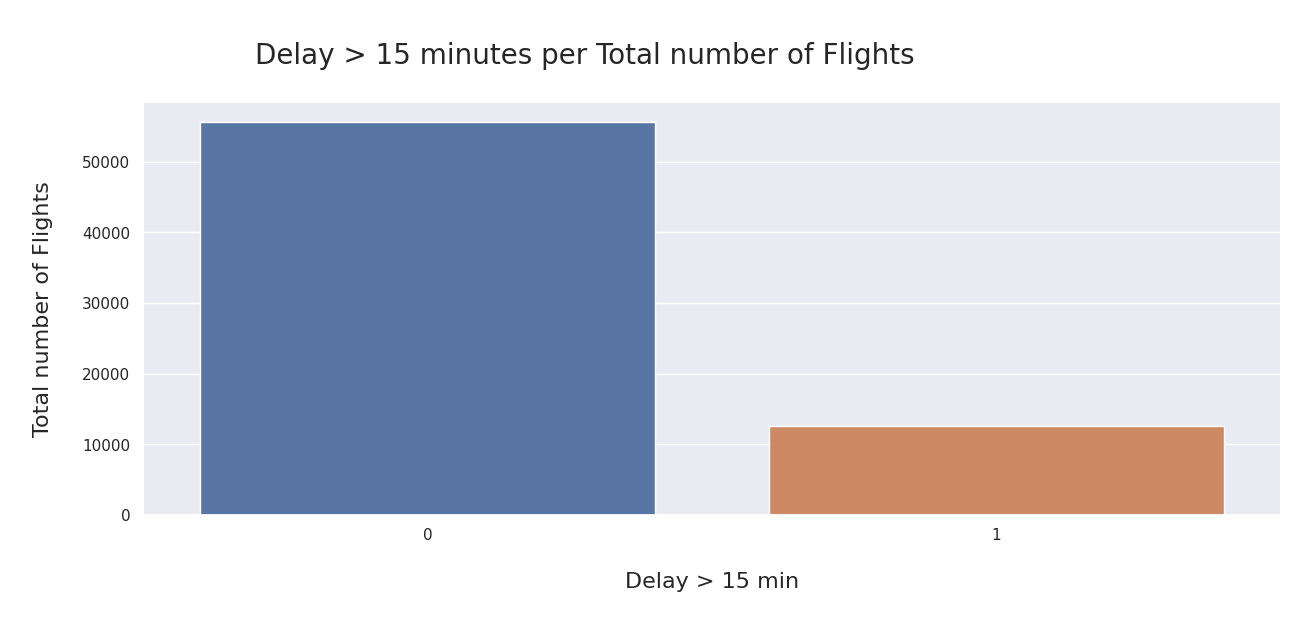

In [172]:
#  is the dataset balanced ?
g = sns.catplot(x="atraso_15", data=dataset, kind="count")
g.set_axis_labels(
    "\nDelay > 15 min\n",
    "\nTotal number of Flights\n",
    size=16,
)
g.fig.suptitle("\nDelay > 15 minutes per Total number of Flights", size=20, y=1.15)
g.figure.set_size_inches(15, 5)

### 4.2 Prepare Dataset for Model

Asssumptions:

1. Only the information for the programmed flight can be used for prediction (Operation data is still unknown at the moment of prediction).
2. Weather data can be know at the moment of prediction because it will be correctly forecasted for most cases.
3. All flights have as origin SCL Airport.

### Check Imbalance Between Classes

In [173]:
class_imbalance = (
    dataset[dataset["atraso_15"] == 0].count()[0]
    / dataset[dataset["atraso_15"] == 1].count()[0]
)
print(f"The class imbalance ratio is: {class_imbalance:.1f} to 1")

The class imbalance ratio is: 4.4 to 1


There is a big imbalance between the binary class to predict, which should be considered when evaluating the performance of the model (If not considered, a random binary model with 50% chance per class would predict the correct class 81.5% of the time with the current imbalance ratio).

Merge all data into one dataset

In [174]:
# concatenate weather data using the datetime information of the flight.
# weather data has a 1-hour interval, so flight time is rounded to the nearest hour.

full_dataset = pd.concat(
    [
        dataset,
        dataset["Fecha-I"].apply(
            lambda x: weather.loc[
                f"{x.year}-{x.month}-{x.day} {round(x.hour+x.minute/60)}:00:00".replace(
                    "24:", "00:"
                ),
                :,
            ]
        ),
    ],
    axis=1,
)
full_dataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,is_holiday,is_school_vacation,Cloud Coverage %,pressure,fog,frost,wind_speed,temperature,rain_mm,relative_humidity
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,1,0.125,960.3,0.0,0.0,13.0,20.6,0.0,0.56
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,1,0.000,959.1,0.0,0.0,14.0,25.4,0.0,0.36
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,0,1,0.500,959.6,0.0,0.0,15.0,24.4,0.0,0.24
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,0,1,0.000,957.9,0.0,0.0,15.0,22.4,0.0,0.39
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,0,1,0.125,955.1,0.0,0.0,11.0,25.3,0.0,0.27


In [175]:
# See correlation of numerical values vs 'dif_min

full_dataset.corr(method="spearman")["dif_min"]

DIA                  -0.009530
MES                   0.094845
AÑO                   0.005201
temporada_alta        0.027534
dif_min               1.000000
atraso_15             0.673003
Vlo-change            0.046132
Des-change            0.007626
Emp-change            0.048564
is_holiday           -0.042830
is_school_vacation    0.038269
Cloud Coverage %      0.012388
pressure              0.016128
fog                   0.028103
frost                 0.047152
wind_speed            0.028799
temperature           0.004622
rain_mm               0.047964
relative_humidity    -0.007794
Name: dif_min, dtype: float64

In [176]:
# See correlation of numerical values vs 'atraso_15

full_dataset.corr(method="spearman")["atraso_15"]

DIA                  -0.002424
MES                   0.082767
AÑO                   0.004394
temporada_alta        0.020332
dif_min               0.673003
atraso_15             1.000000
Vlo-change            0.029310
Des-change            0.005260
Emp-change           -0.007762
is_holiday           -0.025965
is_school_vacation    0.030276
Cloud Coverage %      0.011786
pressure              0.021212
fog                   0.018556
frost                 0.039911
wind_speed            0.036396
temperature           0.005509
rain_mm               0.040658
relative_humidity    -0.010339
Name: atraso_15, dtype: float64

In [177]:
# drop columns associated with 'Operated' Flight
# the assumption is that this data will be unknown at the moment of prediction.
full_dataset.drop(
    columns=[
        "Fecha-O",
        "Vlo-O",
        "Ori-O",
        "Des-O",
        "Emp-O",
        "OPERA",
        "SIGLAORI",
        "SIGLADES",
        "Vlo-change",
        "Des-change",
        "Emp-change",
    ],
    inplace=True,
)

In [178]:
# drop other redundant or unneeded columns
full_dataset.drop(
    columns=["Fecha-I", "Vlo-I", "Ori-I", "DIA", "MES", "AÑO"], inplace=True
)

In [179]:
full_dataset.describe()

,temporada_alta,dif_min,atraso_15,is_holiday,is_school_vacation,Cloud Coverage %,pressure,fog,frost,wind_speed,temperature,rain_mm,relative_humidity
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,0.325646,9.110855,0.184940,0.045172,0.284007,0.369518,961.053268,0.237428,0.053998,5.378412,15.515320,0.020953,0.625254
std,0.468619,19.313387,0.388252,0.207683,0.450944,0.294708,3.439434,0.425510,0.226016,3.986204,7.817259,0.128214,0.229497
min,0.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,953.100000,0.000000,0.000000,0.000000,-3.600000,0.000000,0.080000
25%,0.000000,-1.000000,0.000000,0.000000,0.000000,0.083333,958.600000,0.000000,0.000000,2.000000,9.600000,0.000000,0.440000
50%,0.000000,4.000000,0.000000,0.000000,0.000000,0.347656,960.600000,0.000000,0.000000,4.000000,14.600000,0.000000,0.640000
75%,1.000000,12.000000,0.000000,0.000000,1.000000,0.604167,963.200000,0.000000,0.000000,7.000000,21.100000,0.000000,0.830000
max,1.000000,161.000000,1.000000,1.000000,1.000000,1.000000,974.700000,1.000000,1.000000,22.000000,36.700000,1.866667,1.000000


### Create Training and Testing datasets

In [180]:
# DataFrame for features

X = full_dataset.drop(columns=["dif_min", "atraso_15"])
X.head()

,Des-I,Emp-I,DIANOM,TIPOVUELO,temporada_alta,periodo_dia,MES-DIA,is_holiday,is_school_vacation,Cloud Coverage %,pressure,fog,frost,wind_speed,temperature,rain_mm,relative_humidity
0,KMIA,AAL,Domingo,I,1,noche,1-1,1,1,0.125,960.3,0.0,0.0,13.0,20.6,0.0,0.56
1,KMIA,AAL,Lunes,I,1,noche,1-2,1,1,0.000,959.1,0.0,0.0,14.0,25.4,0.0,0.36
2,KMIA,AAL,Martes,I,1,noche,1-3,0,1,0.500,959.6,0.0,0.0,15.0,24.4,0.0,0.24
3,KMIA,AAL,Miercoles,I,1,noche,1-4,0,1,0.000,957.9,0.0,0.0,15.0,22.4,0.0,0.39
4,KMIA,AAL,Jueves,I,1,noche,1-5,0,1,0.125,955.1,0.0,0.0,11.0,25.3,0.0,0.27


In [181]:
# DataFrame for class to predict
y = full_dataset["atraso_15"]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: atraso_15, dtype: int64

### Encode categorical values to binary columns

Most classification models can't use columns with categorical values (text labels) as features and only support numerical data, so those columns need to be encoded as 0's and 1's in (N-1) different columns with N being the total number of unique labels for that feature.

In [182]:
# Encode categorical columns

categorical_columns = [
    "Des-I",
    "Emp-I",
    "DIANOM",
    "TIPOVUELO",
    "periodo_dia",
    "MES-DIA",
]
# create OneHotEncoder object, drop 1 label per column (only need N-1 to represent all)
encoder = OneHotEncoder(drop="first", sparse=False)
# fit encoder to data (Flighs numbers are integers but should be considered as strings)
encoder.fit(X[categorical_columns].astype(str))

OneHotEncoder(drop='first', sparse=False)

In [183]:
# get names of new columns
encoded_columns = encoder.get_feature_names(categorical_columns)
encoded_columns

array(['Des-I_EGLL', 'Des-I_EGYP', 'Des-I_KATL', 'Des-I_KDFW',
       'Des-I_KIAH', 'Des-I_KJFK', 'Des-I_KLAX', 'Des-I_KMCO',
       'Des-I_KMIA', 'Des-I_LEMD', 'Des-I_LFPG', 'Des-I_LIRF',
       'Des-I_MDPC', 'Des-I_MMMX', 'Des-I_MMUN', 'Des-I_MPTO',
       'Des-I_NZAA', 'Des-I_SAAR', 'Des-I_SABE', 'Des-I_SACO',
       'Des-I_SAEZ', 'Des-I_SAME', 'Des-I_SANT', 'Des-I_SANU',
       'Des-I_SARI', 'Des-I_SAWH', 'Des-I_SAZN', 'Des-I_SAZS',
       'Des-I_SBCT', 'Des-I_SBFI', 'Des-I_SBFL', 'Des-I_SBGL',
       'Des-I_SBGR', 'Des-I_SCAR', 'Des-I_SCAT', 'Des-I_SCBA',
       'Des-I_SCCF', 'Des-I_SCCI', 'Des-I_SCDA', 'Des-I_SCFA',
       'Des-I_SCIE', 'Des-I_SCIP', 'Des-I_SCJO', 'Des-I_SCNT',
       'Des-I_SCPQ', 'Des-I_SCQP', 'Des-I_SCSE', 'Des-I_SCTE',
       'Des-I_SCVD', 'Des-I_SEGU', 'Des-I_SEQM', 'Des-I_SEQU',
       'Des-I_SGAS', 'Des-I_SKBO', 'Des-I_SLCB', 'Des-I_SLLP',
       'Des-I_SLVR', 'Des-I_SPJC', 'Des-I_SPSO', 'Des-I_SULS',
       'Des-I_SUMU', 'Des-I_YMML', 'Des-I_YSSY', 'Emp-I

In [184]:
# how many new columns are there ?
len(encoded_columns)

465

In [185]:
encoder.transform(X[categorical_columns].astype(str))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [186]:
# Add new columns to X dataframe
X = pd.concat(
    [
        X,
        pd.DataFrame(
            encoder.transform(X[categorical_columns].astype(str)),
            columns=encoded_columns,
        ),
    ],
    axis=1,
)
# drop original categorical columns
X.drop(columns=categorical_columns, inplace=True)
X

,temporada_alta,is_holiday,is_school_vacation,Cloud Coverage %,pressure,fog,frost,wind_speed,temperature,rain_mm,...,MES-DIA_9-28,MES-DIA_9-29,MES-DIA_9-3,MES-DIA_9-30,MES-DIA_9-4,MES-DIA_9-5,MES-DIA_9-6,MES-DIA_9-7,MES-DIA_9-8,MES-DIA_9-9
0,1,1,1,0.125000,960.3,0.0,0.0,13.0,20.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1,0.000000,959.1,0.0,0.0,14.0,25.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,0.500000,959.6,0.0,0.0,15.0,24.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1,0.000000,957.9,0.0,0.0,15.0,22.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,1,0.125000,955.1,0.0,0.0,11.0,25.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,1,0,1,0.078125,959.9,0.0,0.0,10.0,26.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68202,1,1,1,0.078125,957.0,0.0,0.0,6.0,28.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68203,1,0,1,0.000000,960.9,0.0,0.0,10.0,26.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68204,1,0,1,0.078125,959.9,0.0,0.0,6.0,27.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into Training and Testing datasets

In [187]:
# Separate data into training (70%) and evaluation (30%).
# data must be stratified to maintain proportion of class imbalance in train and testing

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.3, random_state=50, stratify=y
)

### Normalize numeric data

In [188]:
# Use MinMaxScaler to adjust numeric features to 0-1 range.
# This is done in order to give each column the same initial weight inside the model.
# Shouldn't be applied to boolean columns, or columns already between 0 and 1.

scalar_columns = ["pressure", "wind_speed", "temperature", "rain_mm"]
# declare scaler object with 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
# fit scaler to training data (test data is not used to avoid leakage)
scaler.fit(X_train[scalar_columns])
# transform

MinMaxScaler()

In [189]:
# Transform Training data

X_train[scalar_columns] = pd.DataFrame(
    scaler.transform(X_train[scalar_columns]),
    columns=scalar_columns,
    index=X_train.index,
)
X_train[scalar_columns].head()

,pressure,wind_speed,temperature,rain_mm
18000,0.268519,0.136364,0.461538,0.0
54230,0.171296,0.318182,0.310174,0.0
27232,0.421296,0.181818,0.272953,0.0
63335,0.217593,0.136364,0.419355,0.0
18419,0.212963,0.363636,0.759305,0.0


In [190]:
# Transform Testing data (fitted to training data)

X_test[scalar_columns] = pd.DataFrame(
    scaler.transform(X_test[scalar_columns]), columns=scalar_columns, index=X_test.index
)
X_test[scalar_columns].head()

,pressure,wind_speed,temperature,rain_mm
51896,0.106481,0.454545,0.776675,0.0
43528,0.333333,0.090909,0.196030,0.0
56156,0.203704,0.227273,0.816377,0.0
36469,0.305556,0.181818,0.478908,0.0
20667,0.240741,0.090909,0.359801,0.0


### 4.3 Machine Learning Models

Models selected must be able to handle the class imbalance problem with **class_weight** parameter.

In [191]:
# Define instance of classifier: LogisticRegression
lr = LogisticRegression(
    random_state=50, n_jobs=-1, max_iter=1000, class_weight="balanced"
)

# Define instance of classifier: SVC
svm = SVC(kernel="linear", C=0.025, random_state=50, class_weight="balanced")

# Define instance of classifier: RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators=200, random_state=50, n_jobs=-1, class_weight="balanced"
)

clf_names = [
    "LogisticRegression",
    "Support Vector Classification",
    "RandomForestClassifier",
]
clf = [lr, svm, rfc]

### Train and Compare models using 5-fold cross validation
The **F-1 weighted score** is used as the performance metric, the values vary from 0 (worst) to 1 (perfect) classification.

It's chosen because it considers both **accuracy** and **precision** simultaneously, and the weighted version takes into account the class imbalance.

A 10,000 sub-sample is taken from the training dataset to quickly find the best model with 5-fold cross validation.

In [192]:
# Train the different models and evaluate using a 10,000 sample from training dataset

print("5-fold cross validation using subsets of the training dataset:\n")

for i in range(len(clf_names)):
    print(f"Evaluating Classifier: {clf_names[i]}")
    # Evaluate using F-1 score
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    avg_f1 = []
    for train_ix, test_ix in kfold.split(X_train[:10000], Y_train[:10000]):
        # select rows
        train_X, test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
        train_y, test_y = Y_train.iloc[train_ix], Y_train.iloc[test_ix]
        # train and evaluate classifier
        clf[i].fit(train_X, train_y)
        prediction = clf[i].predict(test_X)
        report = classification_report(test_y, prediction, output_dict=True)
        f1 = report["weighted avg"]["f1-score"]
        print(f"\t- weighted_f1-score for current fold: {f1:.2f}")
        avg_f1.append(f1)
    print(f"\t= average weighted_f1-score: {np.mean(avg_f1):.2f}")

5-fold cross validation using subsets of the training dataset:

Evaluating Classifier: LogisticRegression
	- weighted_f1-score for current fold: 0.68
	- weighted_f1-score for current fold: 0.70
	- weighted_f1-score for current fold: 0.69
	- weighted_f1-score for current fold: 0.68
	- weighted_f1-score for current fold: 0.69
	= average weighted_f1-score: 0.69
Evaluating Classifier: Support Vector Classification
	- weighted_f1-score for current fold: 0.66
	- weighted_f1-score for current fold: 0.67
	- weighted_f1-score for current fold: 0.68
	- weighted_f1-score for current fold: 0.67
	- weighted_f1-score for current fold: 0.65
	= average weighted_f1-score: 0.67
Evaluating Classifier: RandomForestClassifier
	- weighted_f1-score for current fold: 0.76
	- weighted_f1-score for current fold: 0.76
	- weighted_f1-score for current fold: 0.76
	- weighted_f1-score for current fold: 0.76
	- weighted_f1-score for current fold: 0.76
	= average weighted_f1-score: 0.76


As seen above, the best results (0.76) are obtained with the **RandomForestClassifier**, so it's chosen to be used for the full training.

In [193]:
# Train the Best model with the complete training dataset

rfc.fit(X_train, Y_train)
prediction = rfc.predict(X_test)

## 5. Model Evaluation

In [194]:
# Print the Classification Report

print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90     16678
           1       0.51      0.15      0.23      3784

    accuracy                           0.82     20462
   macro avg       0.67      0.56      0.56     20462
weighted avg       0.77      0.82      0.77     20462



### Selection of metric:

The F-1 score was select as the evaluation metric because it's preferable to use when dealing with imbalanced class distribution. It's also of the most used binary classification metrics, representing the harmonic mean of **precision** and **recall**.

In a binary classification problem, the formula is:

$$
 \textrm{F-1 Score} = \frac{2 \times \textrm{Precision} \times \textrm{Recall}}{\textrm{Precision} + \textrm{Recall}}
$$


### Interpretation of results:

Even though the F-1 score is relatively high (0.77), the metrics for class=1 (delayed flight) are a lot worse than for class=0, having to do with the class imbalance and probably the fact that we don't have enough data or features that explain the causes of delay.

### Discover the most important features

In [195]:
# get all names of columns and agreggate the separated scores of categorical features.

cols_desi = []
cols_empi = []
cols_dianom = []
cols_tipovuelo = []
cols_periodo_dia = []
cols_mes_dia = []
score_desi = 0
score_empi = 0
score_dianom = 0
score_tipovuelo = 0
score_periodo_dia = 0
score_mes_dia = 0

for col in X_train.columns:
    if "Des-I" in col:
        cols_desi.append(col)
        score_desi += rfc.feature_importances_[X_train.columns.get_loc(col)]
    elif "Emp-I" in col:
        cols_empi.append(col)
        score_empi += rfc.feature_importances_[X_train.columns.get_loc(col)]
    elif "DIANOM" in col:
        cols_dianom.append(col)
        score_dianom += rfc.feature_importances_[X_train.columns.get_loc(col)]
    elif "TIPOVUELO" in col:
        cols_tipovuelo.append(col)
        score_tipovuelo += rfc.feature_importances_[X_train.columns.get_loc(col)]
    elif "periodo_dia" in col:
        cols_periodo_dia.append(col)
        score_periodo_dia += rfc.feature_importances_[X_train.columns.get_loc(col)]
    elif "MES-DIA" in col:
        cols_mes_dia.append(col)
        score_mes_dia += rfc.feature_importances_[X_train.columns.get_loc(col)]
    else:
        pass

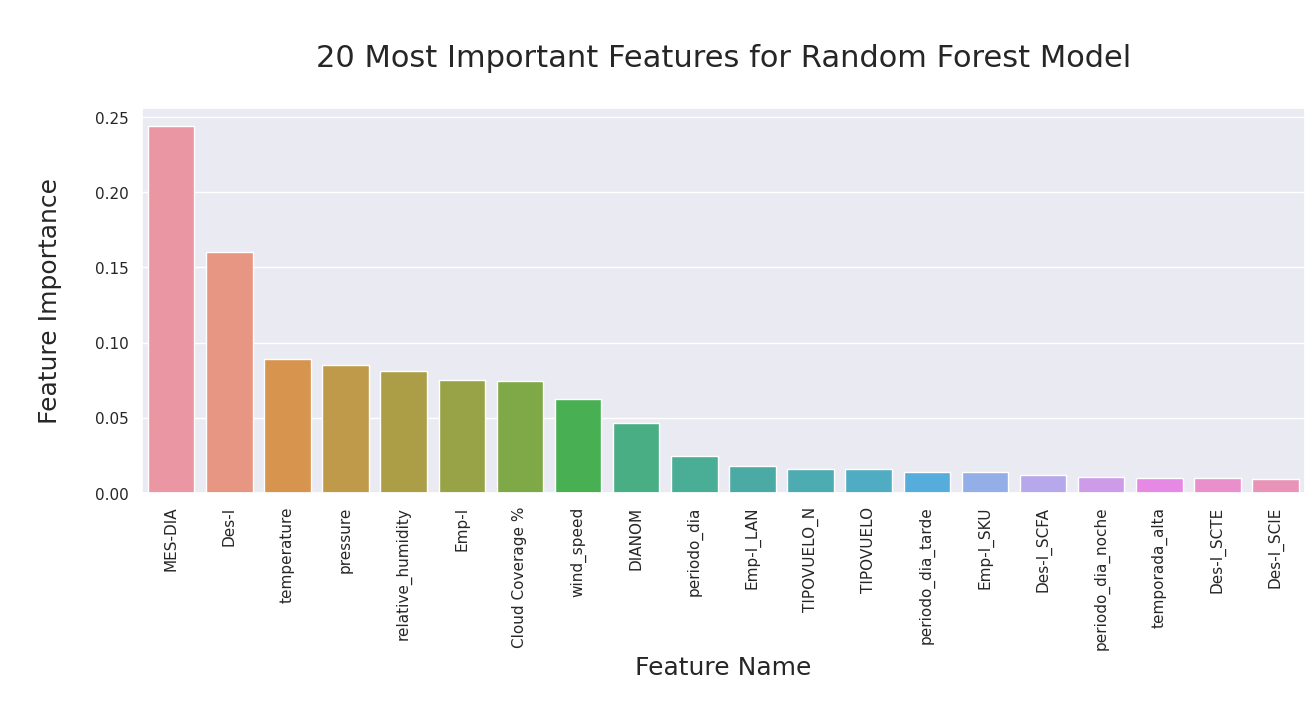

In [196]:
# Find the 20 most important features

# get the names of 14 individual features sorted by importance
sorted_idx = rfc.feature_importances_.argsort()[::-1][:14]
feature_names = X_train.columns[sorted_idx].to_list()
# get the scores of 14 individual features sorted by importance
scores = rfc.feature_importances_[sorted_idx]
# get the 6 categorical features names and scores
feature_names.extend(
    ["Des-I", "Emp-I", "DIANOM", "TIPOVUELO", "periodo_dia", "MES-DIA"]
)
type(scores)
scores = np.append(
    scores,
    [
        score_desi,
        score_empi,
        score_dianom,
        score_tipovuelo,
        score_periodo_dia,
        score_mes_dia,
    ],
)
# join all data in one DataFrame
important_features = pd.DataFrame(data=[scores], columns=feature_names)
# sort columns by scores from highest to lowets
important_features = important_features.T.sort_values(0, ascending=False).T
# Plot the 20 most Important Features
ax = sns.barplot(data=important_features)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="center")
ax.set_title("\n20 Most Important Features for Random Forest Model\n", size=22)
ax.set_ylabel("\nFeature Importance\n", size=18)
ax.set_xlabel("Feature Name\n", size=18)
ax.figure.set_size_inches(15, 5)

### Interpretation of Feature Importance

There are 10 features which are relatively higher in importance, those are:

1. "MES-DIA"
2. "Des-I"
3. "temperature"
4. "pressure"
5. "relative_humidity"
6. "Emp-I"
7. "Cloud Coverage %"
8. "wind_speed"
9. "DIANOM"
10. "periodo_dia"

Of them, 6 are additional features that where introduced from climatological data, showing the importance of weather conditions as a source of delay.

This also means that the original dataset was not enough on its own to completely explain the "delay > 15 minutes" class.

2 of the other features ("Des-I" and "Emp-I") were present on the original dataset, while the other two are synthetic features created from this data and associated to the date.

### How to Increase performance

To increase the performance of the model, we will train the model again selecting the best features and try to optimize the model's hyper-parameters

In [197]:
# Drop low importance features

X_train = X_train.drop(
    columns=['temporada_alta','is_holiday','is_school_vacation','fog','frost','rain_mm']
)
X_test = X_test.drop(
    columns=['temporada_alta','is_holiday','is_school_vacation','fog','frost','rain_mm']
)

In [218]:
# Define Hyper-parameters to tune

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'class_weight': ['balanced']
}

In [219]:
# Use randomized search to find the best hyperparameters

rf_random = RandomizedSearchCV(
    estimator = rfc,
    param_distributions = grid,
    n_iter = 10,
    cv = 2,
    verbose=2,
    random_state=42,
    n_jobs = -1
)

rf_random.fit(X_train[:10000], Y_train[:10000])

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=487; total time=   8.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=487; total time=  10.2s
[CV] END bootstrap=False, class_weight=balanced, max_depth=32, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=1651; total time=  28.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=32, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=1651; total time=  28.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=87, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=875; total time=  30.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=87, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=875

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_estimators=200, n_jobs=-1,
                                                    random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced'],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 3],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 138, 177, 216,
                                                         255, 293, 332, 371,
                                                         410, 448, 487, 526,
                                                         565, 604, 642, 681,
                                                         720, 759, 797, 836,
                                                         875, 914, 953, 991,
                                                         1030, 1069, 1108, 1146,
                                                         1185, 1224, ...]},
                   random_state=42, verbose=2)

In [220]:
rf_random.best_params_

{'n_estimators': 681,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 54,
 'class_weight': 'balanced',
 'bootstrap': False}

In [221]:
# Do a more fine-tuned GridSearch using previous findings

# Create the parameter grid based on the results of random search 
grid = {
    'bootstrap': [False],
    'max_depth': [50, 60],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [5,6],
    'n_estimators': [500, 600, 700],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator = rfc,
    param_grid = grid,
    cv = 2,
    n_jobs = -1,
    verbose = 2
)
grid_search.fit(X_train[:10000], Y_train[:10000])

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=  26.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  26.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=  27.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  28.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  30.3s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=200, n_jobs=-1,
                                              random_state=50),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'class_weight': ['balanced'],
                         'max_depth': [50, 60], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [5, 6],
                         'n_estimators': [500, 600, 700]},
             verbose=2)

In [222]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 700}

In [223]:
# Train the full model again with the best hyperparameters found

# Re-declare the model using the best parameters
rfc = RandomForestClassifier(
    random_state=50,
    n_jobs=-1,
    class_weight="balanced",
    bootstrap = False,
    max_depth = 60,
    max_features = 'sqrt',
    min_samples_leaf = 1,
    min_samples_split = 5,
    n_estimators = 700,
)

# train with the full training dataset
rfc.fit(X_train,Y_train)
prediction = rfc.predict(X_test)
# Print the Classification Report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88     16678
           1       0.43      0.32      0.37      3784

    accuracy                           0.80     20462
   macro avg       0.64      0.61      0.62     20462
weighted avg       0.78      0.80      0.78     20462



After Hyper-Parameter Tuning, and removal of unimportant features, the *weighted F-1 score* was increased to 0.78